<a href="https://colab.research.google.com/github/vgeneva/NN_Backprop/blob/main/iterOCK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [1]:
import numpy as np
# numpy has a random number generator and some
# sampling functionality which we can seed with
# a fixed number to get consistent run results
np.random.seed();
from matplotlib import pyplot as plt
import pandas as pd
from numpy import linalg as LA
from scipy.integrate import solve_ivp  # solve ODE
from matplotlib.animation import PillowWriter    # writing the .gif
import time
import tensorflow as tf
import random

In [2]:
#!pip install kernel_funcs

In [3]:
#from kernel_funcs import *

## Kernel Functions

In [4]:
# A collection of vectorized kernel functions
# x, and y are assumed to be Matrices
# if you want to evaluate on a single point
# reshape the vectors from d to d x 1, this
# will turn them into matrices. All the kernel
# functions work with vectors or matrices with the
# exception of k5v which requires matrices as inputs.

# Linear kernel, notice, if x, and y
# are vectors, this will return a scalar
# if x, and y are matrices, this will
# return a matrix and this is an efficient
# and vectorized implementation of the linear
# kernel function.
def k1v(x,y):
    # np.dot computes the vector dot
    # product if x, and y are vectors
    # or it computes the matrix product
    # of x and y, if x or y are matrices
    return (np.dot(x,y.T))

# Affine kernel. Again, if x and y are
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the affine kernel.
def k2v(x,y):
    return (np.dot(x,y.T)+1)

# Quadratic kernel. Again, if x and y are
# vectors, this will return a scalar but
# if x, and y are matrices this is a vectorized
# version of the Quadratic kernel.
def k3v(x,y):
    # To raise a number by a power python
    # uses ** instead of ^, ^ is reserved
    # for bit operations. (and?)
    return ((1+np.dot(x,y.T))**2)

# dth order kernel, (here d=4)
d = 4
def k4v(x,y):
    return ((1+np.dot(x,y.T))**d)

# Gaussian kernel. This is the only kernel function
# in this set of example kernels that is tricky to
# efficiently vectorize. This is because to evaluate
# this kernel function, we have to evaluate (x-y)^T(x-y)
# whereas in all the other examples, we evaluate x^Ty
# Expanding (x-y)^T(x-y) gives us x^Tx - 2x^Ty + y^Ty
# So k(x_i,y_j) = e^(-(x_i-y_j)^T(x_i-y_j)/(2*sigma^2))
# So k(x_i,x_j) = f(x_i^Tx_i+y_j^Ty_j-2x_i^Ty_j)
# we get x_i^Ty_j using np.dot(X,Y) where X and Y are the
# X and Y data matrices respectively. We get x_i^Tx_i using
# np.sum(X*X,axis=1).reshape(d,1). This function requires
# matrices and will fail if x, or y are vectors. It is
# vectorized and efficient. For any kernel function that uses
# k(x_i,x_j) = f((x_i-x_j)^T(x_i-x_j)) use the line that
# computes XminusYSquared to compute the matrix whose i,jth
# entry is (x_i-x_j)^T(x_i-x_j) in a vectorized and efficient
# manner. Then apply f(XminusYsquared).

# sigma can be picked for the specific problem at hand
sigma = 2**0;
def k5v(x,y):
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]);
    return np.exp(-XminusYSquared/(2*sigma**2))


def gauss_0(x,y): # zero boundary conditions
    numxPoints = np.shape(x)[0];
    numyPoints = np.shape(y)[0];
    XminusYSquared =np.sum(x*x,axis=1).reshape([numxPoints,1])-2*np.dot(x,y.T)+np.sum(y*y,axis=1).reshape([1,numyPoints]);
    return np.exp(-XminusYSquared/(2*sigma**2))

# Hyperbolic tangent vectorized kernel function
kappa=1
theta=1
def k6v(x,y):
    return (np.tanh(kappa*np.dot(x,y.T)+theta));

def k7v(x,y):
    return np.exp(-1/(2*sigma**2) * (x-y)**2)
# Set the kernel function to be whatever we choose
# in this case the gaussian kernel
k = k5v;

## Making constant $\gamma$.

In [5]:
# I am creating a constant function using some random number
r = random.random()
print(r)

0.17566492636469466


In [6]:
# Here is the constant function
def gamma(x, random_number = r):
  return r

In [7]:
# test
print(gamma(4))
print(gamma(8))

0.17566492636469466
0.17566492636469466


## Integrating $\gamma$.

In [8]:
#(.9-.1 + h_x)/.01



In [9]:
## starting trajectory

h_x = 0.01
a = .1
b = .9
#k_x = int(1/h_x)
k_x = int((b- a + h_x)/h_x)
print(k_x)
#x_input = np.reshape(np.arange(0, 1 + h_x, step = h_x), (k_x + 1, 1))
x_input = np.reshape(np.arange(.1, .9 + h_x, step = h_x), (k_x, 1))
#print(x_input)
print(x_input.shape)
df_x_input = pd.DataFrame(x_input)
df_x_input.describe()

81
(81, 1)


,0
count,81.000000
mean,0.500000
std,0.235266
min,0.100000
25%,0.300000
50%,0.500000
75%,0.700000
max,0.900000


In [10]:
#x_input

In [11]:
# this is my differential equation for my constant function
# we need to add 't' as our time variable for the integrator
def f(t, x):
  fx = gamma(x)
  return fx

In [12]:
# time intervals for my ODE integrator
num = 10
t_list = np.linspace(0, 1.0, num = num)
#print(t_list)

In [13]:
sol_1 = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)

In [14]:
print(sol_1.y[:,0])
print(sol_1.y[:,-1])
print(sol_1.y.shape)

[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 ]
[0.27566493 0.28566493 0.29566493 0.30566493 0.31566493 0.32566493
 0.33566493 0.34566493 0.35566493 0.36566493 0.37566493 0.38566493
 0.39566493 0.40566493 0.41566493 0.42566493 0.43566493 0.44566493
 0.45566493 0.46566493 0.47566493 0.48566493 0.49566493 0.50566493
 0.51566493 0.52566493 0.53566493 0.54566493 0.55566493 0.56566493
 0.57566493 0.58566493 0.59566493 0.60566493 0.61566493 0.62566493
 0.63566493 0.64566493 0.65566493 0.66566493 0.67566493 0.68566493
 0.69566493 0.70566493 0.71566493 0.72566493 0.73566493 0.74566493
 0.75566493 0.76566493 0.77566493 0.78566493 0.79566

In [15]:
# time  = 0, 0.25, 0.50, 0.75, 1.0 are the columns
# input is the the rows
sol_1.y.shape

(81, 10)

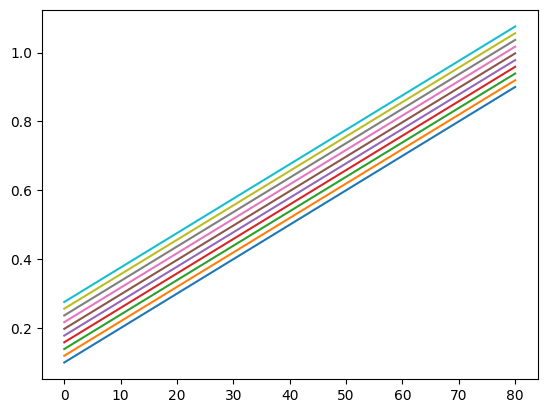

In [16]:
for a in range(0,num):
  plt.plot(sol_1.y[:,a])

## Double integral function

Below is our composite trapezoid quadrature for $L^*$. We need this matrix to help compute the gradient. We use the ODE solver intermediate time steps.

\begin{align}
    &\int_0^1 \int_0^1  K(x_k(s),x_l(t) dsdt \notag\\
    &\approx \frac{h^2}{4} \left[ K(x_k(s_0),x_l(t_0) +K(x_k(s_0),x_l(t_{p}) \right.\notag \\
    & \left. + K(x_k(s_{p}),x_l(t_0)  +K(x_k(s_{p}),x_l(t_{p}) \right] \notag\\
    & +\frac{h^2}{2} \left[ \sum_{j=1}^{p-1} K(x_k(s_0),x_l(t_j) +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_{p})+\sum_{j=1}^{p-1}K(x_k(s_{p}),x_l(t_j) \right. \notag \\
    &\left. +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_0) \right]  +  h^2 \left[ \sum_{j=1}^{p-1} \sum_{i=1}^{p-1} K(x_k(s_i),x_l(t_j)\right]
\end{align}
where $k,l \in \lbrace 0, \dots, n\rbrace$, $i,j \in \lbrace 1,\dots p-1 \rbrace$ ($p$ is the number of intermediate trajectories ($x_i)$ we choose), and for our given bounded $[0,1]$ interval, $h = (1-0)/(p-1)$.  Use the convolve function to find this value.


In [17]:
# Convolution for double integral

def con(h, y, num, kern):  #y is sol.y, kern is the kernel we choose
                            # h  = 1/(p-1)

    #make kernel for trap
    kernel_1 = (h**2 / 4) * np.array([[1,1],
                                  [1,1]]
                                )
    #repshape for tensor flow
    kernel_1  = np.reshape(kernel_1, (kernel_1.shape[0], kernel_1.shape[1], 1,1))
    #make into a tensor flow
    kernel_1 = tf.constant(kernel_1, dtype = tf.float64)

    #make 2nd kernel
    kernel_2 = np.full((num-1, num-1), 1) #has to do with intermediate trajectories
    #kernel_2 =np.array([[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
    kernel_2 = np.reshape(kernel_2, (kernel_2.shape[0], kernel_2.shape[1], 1,1))
    kernel_2 = tf.constant(kernel_2, dtype = tf.float64)

    #I'll need another kernel for number for num.  I will need num-1, 1's
    #kernel_3 = np.array([[1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1],
    #                     [1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1],
    #                     [1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1]])
    #kernel_3 = np.reshape(kernel_3, (kernel_3.shape[0], kernel_3.shape[1], 1,1))
    #kernel_3 = tf.constant(kernel_3, dtype = tf.float64)


    # Take our solution (100 x 5) and make into a 500 x 1
    y = y.flatten()
    y = np.reshape(y, (len(y),1))
    #print('After sol.y is flattented we have: ' +str(y.shape))
    matrix = kern(y, y)   #make into 500 x 500 matrix for num  =5, num =10 shouuld be 1000x10000
    #print(matrix.shape)
    matrix = np.float_(matrix)  #make sure all not integers

    #repshape for tensor flow
    #print(matrix[1])
    # batch is the first position, and we don't have any
    # channels is last position and we don't have any
    # really we just want the (n,n) in the middle
    matrix = np.reshape(matrix, (1, matrix.shape[0], matrix.shape[1], 1))
    #make into a tensor flow
    matrix = tf.constant(matrix, dtype = tf.float64)

    # 1st convolve:
    # i believe the 1's on the outside don't do anthing, we just need the middles to tell
    # the kernel how to convolve
    con_1 = tf.nn.conv2d(matrix, kernel_1, strides = [1,1,1,1],padding = 'VALID')
    #print(con_1.shape)
    # 2nd convolve:
    con_2 = tf.nn.conv2d(con_1, kernel_2, strides = [1,num,num,1],padding = 'VALID') #kernel_2 versus 3

    # back to numpy
    con_2 = con_2.numpy()
    #print(con_2.shape)
    # reshape to nxn
    con_2 = np.reshape(con_2, (con_2.shape[1], con_2.shape[2]))
    #print(con_2.shape)

    ## TO DO put back to tensor

    return con_2

In [18]:
#K star for each, input solutions to ivp and the h
def K_Lstar(v,w,h,kern):
    # Take our solution (100 x num) and make into a 100*num x 1
    v = v.flatten()
    #print(v.shape)
    v = np.reshape(v, (len(v),1))

    w = w.flatten()
    w = np.reshape(w, (len(w),1))

    Kstar = kern(v,w)
    Kstar = Kstar.numpy()
    #Kstar = np.float_(Kstar)  #to ensure that all values are floats and can be mupltiplied by 1/2
    #print(Kstar.shape)
    Kstar[:, 0]  *= 1/2  #scale first column by 1/2
    Kstar[:,-1]  *= 1/2  #scale last column by 1/2
    Kstar[0, :]  *= 1/2  #scale first row by 1/2
    Kstar[-1,:]  *= 1/2  #scale last row by 1/2
    Kstar *= h**2
    return Kstar

## Creating the first $L^*$ based on $\gamma$

This kernel is the guassian kernel. In order to ensure we are statying consistant, we need to input the kernel function we want. Later we will use $k_0(x,y) = \psi_0(x)^T \psi_0(y)$, where $\psi_0$ is our new feature vector that makes the boundaries go to zero.

In [19]:
L_star = con(h_x, sol_1.y, num, k) # this is just the gaussain k - kv5

In [20]:
L_star

array([[0.00807872, 0.00807832, 0.00807712, ..., 0.00596931, 0.00592288,
        0.00587622],
       [0.00807832, 0.00807872, 0.00807832, ..., 0.0060155 , 0.00596931,
        0.00592288],
       [0.00807712, 0.00807832, 0.00807872, ..., 0.00606146, 0.0060155 ,
        0.00596931],
       ...,
       [0.00596931, 0.0060155 , 0.00606146, ..., 0.00807872, 0.00807832,
        0.00807712],
       [0.00592288, 0.00596931, 0.0060155 , ..., 0.00807832, 0.00807872,
        0.00807832],
       [0.00587622, 0.00592288, 0.00596931, ..., 0.00807712, 0.00807832,
        0.00807872]])

In [21]:
L_star.shape

(81, 81)

## Function for single integral for $\alpha$.

Create $\alpha(x)$. Below is our quadrature for $\alpha$. Again $p$ is the number of intermediate trajectories we choose and $h = 1/p$.  Recall $\alpha(x) = \sum_{k=1}^n \beta_k L^*_{x_{k}}(x)$, where $L^*_{x_{k}}(x) = \int K(x_k(s),x)dt$.
\begin{align}
    &\int_0^1  K(x_k(s),x) ds \notag \\
    &\approx \frac{h}{2} K(x_k(s_0),x) + h  \sum_{i=1}^{p-1} K(x_k(s_i),x) + \frac{h}{2}  K(x_k(s_p),x)
\end{align}
We again use the trapezoid composite rule where $k \in \lbrace 1, \dots, n\rbrace$ and $i \in \lbrace 0,\dots, p-1 \rbrace$ for our minimizer $\alpha$.

In [22]:
#Function for single integral: middle term from trapezoid rule
def GetMid(U, y, N, kern): #N is num, y is sol.y, U is the open varialbe
                            #kern is the kernel we choose
  mid = [0] * (N-2)  #there will be N-2 items in the middle (not the first or the last), I added this before it was N
  #print("in mid now")
  #print(f"This is the shape of U: {U.shape}")
  #print(f"This is the len of U: {len(U)}")
  for i in range(1,N-1):
    # print(f"{i = }")
    mid[i-1] = kern(U.reshape(len(U),1),y[:,i:i+1]) # I added i - 1 before it was i but i starts at 1 here.
    # print(f"mid[i] = {mid[i]} = k(U.reshape(len(U),1),y[:,{i}:{i+1}])")
  return np.sum(mid, axis=0) # row sum

# n = num (the variable from above)
# this function takes middle term and sums the first and last summand from the trapezoid rule
def Gamma(H, U, y, N, kern): #N is num, y is sol.y, U is the open varialbe, H is h or 1/(p-1)
  #print("in beg")
  #print(f"This is the shape of U: {U.shape}")
  #print(f"This is the len of U: {len(U)}")
  #np.reshape(U,len(U))
  #print(f"This is the shape of U: {U.shape}")
  #print(f"This is the len of U: {len(U)}")
  beg = H/2 * kern(U.reshape(len(U),1),y[:,0:1])
  #print(y[:,0:1].shape)
  #print(beg.shape)
  #print(U.shape)
  # print(f"beg = {beg} = H/2 * k(U.reshape(len(U),1),y[:,0:1])")
  mid = H * GetMid(U, y, N, kern)
  #print(mid.shape)
  end = H/2 * kern(U.reshape(len(U),1),y[:,N-1:N])
  # print(f"end = {end} = H/2 * k(U.reshape(len(U),1),y[:,n-1:n])")

  return beg+mid+end

In [23]:
arr = np.array([[1,2,3,1], [2,3,3,1], [5,5,5,1],[2,2,2,1]])
print(arr)
print(arr[:,2:3])
print(np.reshape(arr[:,-1], (len(arr[:,-1]),1)))
print(len(arr[0]))
N = len(arr[0])

mid = [0] * (N-2)

for i in range(1,N-1):
    # print(f"{i = }")
  print(i)
  mid[i-1] = arr[:,i:i+1]
  print(mid[i-1])

[[1 2 3 1]
 [2 3 3 1]
 [5 5 5 1]
 [2 2 2 1]]
[[3]
 [3]
 [5]
 [2]]
[[1]
 [1]
 [1]
 [1]]
4
1
[[2]
 [3]
 [5]
 [2]]
2
[[3]
 [3]
 [5]
 [2]]


## Creating $\alpha$, and $\phi_0$ and $\phi_1$.

First we leverage Michael's code to create a fourier features map we denote as $\psi(x)$. Our inputs for this function are: an $x$ value, fourier_sample (which are scaling the inputs into the $\sin$ and $\cos$ components of the vector), and a feature coefficient which in our case is $1 / \sqrt{\text{number of features}}$. \begin{align}
    \psi(x) = \frac{1}{\sqrt{p}} \begin{bmatrix}
        \cos(z_1x) \\
        \vdots\\
        \cos(z_{p/2}x)\\
        \sin(z_1x)\\
        \vdots\\
        \sin(z_{p/2}x)
    \end{bmatrix}
\end{align}

In [24]:
#feature map: Computes a feature map for a Gaussian kernel Fourier features approximation.
#Input:
#x - (n,d) matrix of n d-vectors to perform feature map on
#fourier_sample - (d,p) matrix of p samples from a d-dimensional standard normal distribution
#feature_coeff - 1/sqrt(p).  This could be computed from fourier_sample.
#Output:
#M - (2p+1,n) matrix of n feature vectors
#The +1 comes from the fact that this feature vector incorporates a constant term
# in regards to bandwidth, we are sampling from a normal distribution but using the guassian kernel.
# so we need to make our standard deviation 1/sqrt(\sigma^2). Here , when i selet
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).
def feature_map(x,fourier_sample,feature_coeff,bandwidth = .5):  #oritingal 0.1#bandwith is the sigma

    x = tf.transpose(x) #make x into a tensor for this calc
    fourierx = tf.linalg.matmul(fourier_sample,x)
    cos_fourierx = feature_coeff*tf.cos(fourierx/bandwidth)
    sin_fourierx = feature_coeff*tf.sin(fourierx/bandwidth)
    M = tf.concat([cos_fourierx,sin_fourierx],axis=0)

    return M

Here we generate a seed.

In [25]:
np.random.seed(15)

Make an $\alpha$ function in order to generate our $\phi_1$ using our featur_map_alpha defined above. We want to ensure that $\alpha(0) = \alpha(1) = 0$.

First we leverage Michael's code to create a fourier features map we denote as $\phi^*(x)$. Our inputs for this function are: an $x$ value, fourier_sample (which are scaling the inputs into the $\sin$ and $\cos$ components of the vector), and a feature coefficient which in our case is $1 / \sqrt{\text{number of features}}$.

We define the number for features for our $\phi_0$ and $\alpha$ as num_features. We needed to take into consideration that the fourier features map will be 'num_features' cosine functions but each cosine function has a corelated sine function, so the fourier feature map is 2 * num_features.

In [26]:
num_features_alpha = 1000

We will generate two functions: $\phi_0$ and $\alpha$ by generating two seperate $\Theta$ vectors. The $\Theta$'s are generated by sampling from a normal distribution with specific standard deviations dependent on the num_features. This sampling is discussed in the paper by Dr. Bruno. We will have:
$$\phi_0(x) =  \Theta_1^T \phi^*(x)$$
$$\alpha(x) = \Theta_2^T \phi^*(x)$$
Below is the generation of $\Theta_1$ and $\Theta_2$. We must then make the numpy arrays into constant tensoflow arrays as seen below by tf.constant(theta1).

We then generated the fourier_sample vector which will be scaling the inputs to the cosine and sine component functions. These are generated by using a normal distrubtion with standard deviation of 1. We again had to convert the fourier_samples into a tensorflow array.

Then we have our feature_coefficient variable here defined as $1/2*\sqrt{\text{num_features}}$.

In [27]:
# creating theta1 for phi_0
theta1 = np.random.normal(scale = 10 / np.sqrt(num_features_alpha),size = (2 * num_features_alpha, 1))
theta1 = tf.constant(theta1)

In [28]:
# creating theta2 for alpha, note that i subtracted 2 from 2*num_features since
# we go down 2 dimensions
#theta2 = np.random.normal(scale = 1.0, size = ((2 * num_features_alpha)-2, 1))
theta2 = np.random.normal(scale = 10 / np.sqrt(num_features_alpha), size = ((2 * num_features_alpha)-2, 1)) /20
#theta2 = np.random.normal(scale = 10, size = ((2 * num_features_alpha)-2, 1)) /20
theta2 = tf.constant(theta2)

# using guass kernel, so no need to decrease dimenson
theta2_gauss = np.random.normal(scale = 10 / np.sqrt(num_features_alpha), size = ((2 * num_features_alpha), 1)) /20
theta2_gauss = tf.constant(theta2_gauss)

# Z's

In [29]:
#np.random.normal?

In [30]:
# creating fourier samples (create a vector of random numbers to be the scale inputs, which are x)
# in the feature_map, we have cosines and sines and we have num_features cosines, so that means we will need
# num_features sines for the fourier features. Our input then is num_features, but our vector col will be
# 2 * num_features_alpha.

# we need to make our standard deviation 1/sqrt(\sigma^2). Here , when i selet
# fourier, sample, its with sigma = 1, so this is 1\sqrt (1).

#fourier_sample_alpha = np.random.normal(size = (num_features_alpha,1))  #these are the randomly picked z's for the fourier-features
fourier_sample_alpha = np.random.normal(scale = 1, size = (num_features_alpha,1))

#fourier_sample_alpha  = np.reshape(np.linspace(-3, 3, num_features_alpha), (num_features_alpha,1))
fourier_sample_alpha = tf.constant(fourier_sample_alpha)

#feature_coeff_alpha = 1 / np.sqrt(2 * num_features_alpha)
feature_coeff_alpha = 1 / np.sqrt(num_features_alpha)

In [31]:
print(np.std(fourier_sample_alpha))

1.0095372297107705


In [32]:
# normal guassian
def k9v(x,y, fourier_sample = fourier_sample_alpha,
            feature_coeff = feature_coeff_alpha,
          feature_map = feature_map):

    return tf.linalg.matmul(tf.transpose(feature_map(x, fourier_sample, feature_coeff))
                                                       , feature_map(y, fourier_sample
                                                       , feature_coeff))

(81, 81)


1.4681868082902077e+18

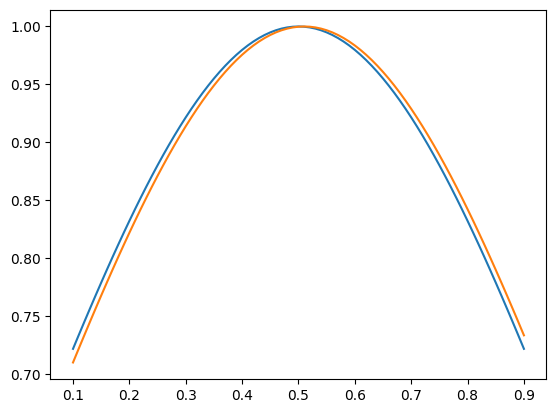

In [33]:
kern_gaus_test = k9v(x_input,x_input)
plt.plot(x_input,k9v(x_input,x_input)[40,:]);
plt.plot(x_input,k9v(x_input,x_input)[41,:]);
print(kern_gaus_test.shape)
np.linalg.cond(kern_gaus_test)

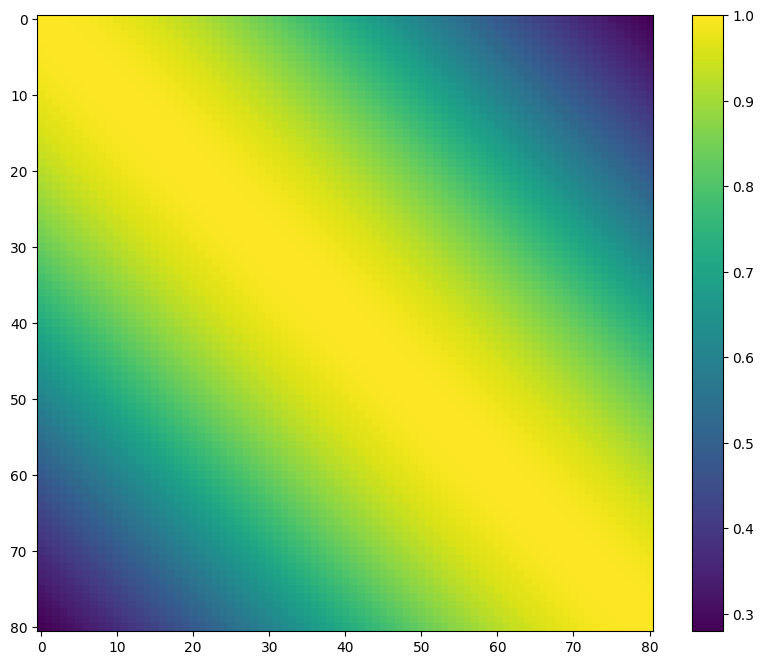

In [34]:
plt.figure(figsize = (10,8))
plt.imshow(kern_gaus_test);
plt.colorbar();

Using $k_0(x,y) = \psi(x)^T A \psi(y)$

When we generated our $\alpha$ function, we ensured that the $\alpha(0) = \alpha(1) = 0$.  We did this by following Dr. Bruno's notes on A RKHS constrained to functions verifying $\alpha(0) = 0$ and $\alpha(1) = 0$. We first start by considering an explicit kernel with random fourier features: $k(x,y)  = \psi(x)^T \psi(y)$

In [35]:
def g(x, y, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha):
  return tf.linalg.matmul(tf.transpose(feature_map(x, fourier_sample, feature_coeff)),
                          feature_map(y, fourier_sample, feature_coeff))

First make tensor flow arrays for $x_1 = [1], x_0 =[0], x_{01} =[0 ,1 ]$.

In [36]:
x_01 = np.array([0.,1.])
# reshape x_1 into a column vector
x_01 = np.reshape(x_01, (len(x_01),1))
#print(x_01.shape)
# make numpy array into a tensorflow array
x_01 = tf.constant(x_01)

In [37]:
x_0 = np.array([0.])
x_0 = np.reshape(x_0, (len(x_0),1))
#print(x_0.shape)
# make numpy array into a tensorflow array
x_0 = tf.constant(x_0)
#print(x_0.shape)

In [38]:
x_1 = np.array([1.])
x_1 = np.reshape(x_1, (len(x_1),1))
#print(x_1.shape)
# make numpy array into a tensorflow array
x_1 = tf.constant(x_1)
#print(x_1.shape)

Now, let's create a gram matrix with our end points, $x = [0,1]$. Here we make  
G =\begin{bmatrix} k(0,0) & k(0,1) \\
                      k(0,1) & k(1,1)
      \end{bmatrix}

In [39]:
G = g(x_01,x_01)
print(G)
G_inv = tf.linalg.inv(G)
print(G_inv)

tf.Tensor(
[[1.         0.14496867]
 [0.14496867 1.        ]], shape=(2, 2), dtype=float64)
tf.Tensor(
[[ 1.02146707 -0.14808072]
 [-0.14808072  1.02146707]], shape=(2, 2), dtype=float64)


$(\psi(0),\psi(1))$, with $\psi(0), \psi(1) \in \mathbb{R}^p$.

In [40]:
p_0p_1 = feature_map(x_01, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha)
print(p_0p_1.shape)

(2000, 2)


$(\psi(0), \psi(1)) G^{-1} (\psi(0), \psi(1))^T$

In [41]:
pGp = tf.linalg.matmul(tf.linalg.matmul(p_0p_1, G_inv), tf.transpose(p_0p_1))
print(pGp.dtype)
print(pGp.shape)

<dtype: 'float64'>
(2000, 2000)


In [42]:
I = tf.eye(2 * num_features_alpha, dtype=tf.float64)

$A = I - (\psi(0), \psi(1)) G^{-1} (\psi(0), \psi(1))^T$

In [43]:
A_g = tf.subtract(I,pGp)
print(A_g.shape)
#print(A_g)

(2000, 2000)


In [44]:
# A Hermitian matrix is a square matrix that is equal to its own complex conjugate transpose.
if np.allclose(A_g, np.conj(A_g).T):
    print("A is Hermitian")
else:
    print("A is not Hermitian")

A is Hermitian


In [45]:
# Use eigh
eig, U = LA.eigh(A_g)

In [46]:
# Define the condition for removing small values from
# eigenvalues. These are basically zero
condition = eig < 1e-14

# Use boolean indexing to select the elements that satisfy the condition
# this is telling me what meets the condition
remove = tf.boolean_mask(eig, condition)
# Obtain indexes where this condition is met
ind_to_remove = np.where(condition)

# new eig vector with no zeros
new_eig = np.delete(eig, ind_to_remove)
#new_eig = np.where(condition, eig, 0)

# new U matrix removing the eigenvectors corresponding to
# eigenvalues that were removed
new_U = np.delete(U, ind_to_remove, axis=1)


print(remove)
print(ind_to_remove)
print(new_eig)
print(new_eig.shape)
print(new_U.shape)
print(new_U[:,0].shape)

tf.Tensor([-7.30934419e-17  1.18331645e-15], shape=(2,), dtype=float64)
(array([0, 1]),)
[1. 1. 1. ... 1. 1. 1.]
(1998,)
(2000, 1998)
(2000,)


In [47]:
new_L = tf.linalg.diag(tf.sqrt(new_eig))
print(new_L.shape)

(1998, 1998)


$Λ^{1/2} U^T$ will be the same, so I don't need to recalculate every time we go through the equation.

In [48]:
LU = tf.linalg.matmul(new_L, tf.transpose(new_U))
print(LU.shape)

(1998, 2000)


In [49]:
np.linalg.cond(LU)

1.0000000000000038

$\psi_0(x) = Λ^{1/2}U^T \psi(x)$

In [50]:
# new feature map to make alpha and learning alpha
def feature_map_0(x, Lambda_unitary, fourier_sample = fourier_sample_alpha,
                  feature_coeff = feature_coeff_alpha, feature_map = feature_map):
  p = feature_map(x, fourier_sample, feature_coeff)
  return tf.linalg.matmul(Lambda_unitary, p)

(1998, 1)
(1998, 1)


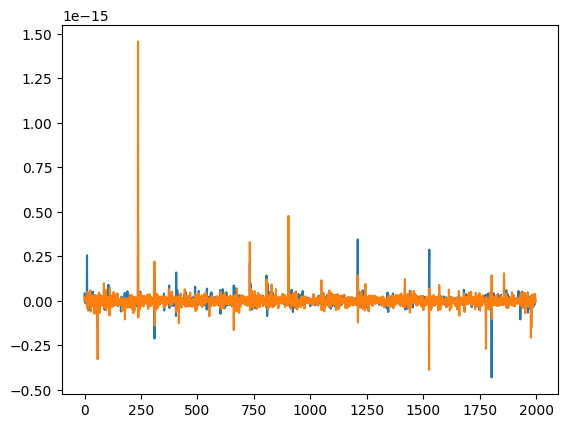

In [51]:
# An input of 1 dimensional vector should be (p-2,1)
# this graphs should show that psi_0(0) ≈ 0, psi_0(1) ≈ 0
f_0 = feature_map_0(x_0, LU)
print(f_0.shape)
f_1 = feature_map_0(x_1, LU)
print(f_1.shape)
plt.plot(f_0)
plt.plot(f_1)

In [52]:
#x, Lambda_unitary, fourier_sample = fourier_sample_alpha,
#                  feature_coeff = feature_coeff_alpha, feature_map = feature_map

# Where I start to make phi_0 and alpha

In [53]:
# Generate function

# for phi_0
def gen_func(x, theta, fourier_sample, feature_coeff, feature_map=feature_map):
    return tf.linalg.matmul(tf.transpose(theta), feature_map(x,fourier_sample,feature_coeff))


# for alpha, using projection, the theta for this needs to be (p-2,1) dimensions.
def gen_func_1(x, theta,
               fourier_sample = fourier_sample_alpha,
               feature_coeff = feature_coeff_alpha,
               feature_map = feature_map,
               Lambda_unitary = LU):
  #print(theta.shape)
  #A = feature_map_0(x, Lambda_unitary)  #feature map (p-2,1) dimensions
  # something is up with this
  A = feature_map_0(x, Lambda_unitary, fourier_sample,
                  feature_coeff, feature_map)

  #print(A.shape)
  return tf.linalg.matmul(tf.transpose(theta), A)

In [54]:
# make an x to input into this function
x = tf.constant(np.array([27.0]))
print(x.shape)
x = x[None,:] #row vector
print(x.shape)
print(x)

(1,)
(1, 1)
tf.Tensor([[27.]], shape=(1, 1), dtype=float64)


In [55]:
# test out
gen_func(x, theta1, fourier_sample_alpha, feature_coeff_alpha)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.31351741]])>

In [56]:
print(x.dtype)
print(theta2.shape)
print(LU.shape)

<dtype: 'float64'>
(1998, 1)
(1998, 2000)


In [57]:
# test out
gen_func_1(x, theta2)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.02593766]])>

Here we generated $\phi_0$ and $\alpha$. This correspoinds to
$$\phi_0(x) =  \Theta_1^T  \psi_0(x) = \Theta_1^T \Lambda^{1/2} U^T \psi(x)$$
$$\alpha(x) = \Theta_2^T \psi_0(x) = \Theta_2^T \Lambda^{1/2} U^T \psi(x)$$

In [58]:
theta3 = np.random.normal(scale = 10 / np.sqrt(num_features_alpha), size = ((2 * num_features_alpha)-2, 1)) /20
theta3 = tf.constant(theta3)

In [59]:
def h_func(t, x, theta = theta3, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha):
    #return gen_func_1(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff) # gen_func_1 usi
    return gen_func_1(x, theta, fourier_sample, feature_coeff)

In [60]:
def phi_0(x,theta = theta1, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha):
    #return gen_func(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff)#this uses normal feature_map for a normal function
    return gen_func(x, theta, fourier_sample, feature_coeff)
# this is our ODE that uses feature_map_alpha to ensure 0's are at a(0) = a(1) = 0
# using Dr. Bruno algorithm
# put a t in here in order to use sol_ivp function
def alpha(t, x, theta = theta2, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha):
    #return gen_func_1(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff) # gen_func_1 usies LU, here we placed feature_map_alpha to ensure we have 0 on bounderies
    return gen_func_1(x, theta, fourier_sample, feature_coeff)


def alpha_gauss(t, x, theta = theta2_gauss, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha):
    #return gen_func(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff) # This uses normal feature_map
    return gen_func(x, theta, fourier_sample, feature_coeff)

In [61]:
phi_0(x)   #we only need to input x, because the other variables are pre-defined.

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.31351741]])>

In [62]:
alpha(1, x)   #we only need to input x, because the other variables are pre-defined.

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.02593766]])>

In [63]:
alpha_gauss(1, x)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.02751651]])>

In [64]:
alph = alpha#alpha_gauss

We needed to reshape the x input array into a tensorflow array.

In [65]:
# reshape x_input into a column vector
x_input = np.reshape(x_input, (len(x_input),1))
print(x_input.shape)
# make numpy array into a tensorflow array
x_input = tf.constant(x_input)
print(x_input.shape)

(81, 1)
(81, 1)


Here is our data generated for $\phi_0(x)$ and $\alpha$ with the input of x_input as well as their plots.  

In [66]:
phi_0(x_input).shape

TensorShape([1, 81])

Text(0, 0.5, 'phi_0')

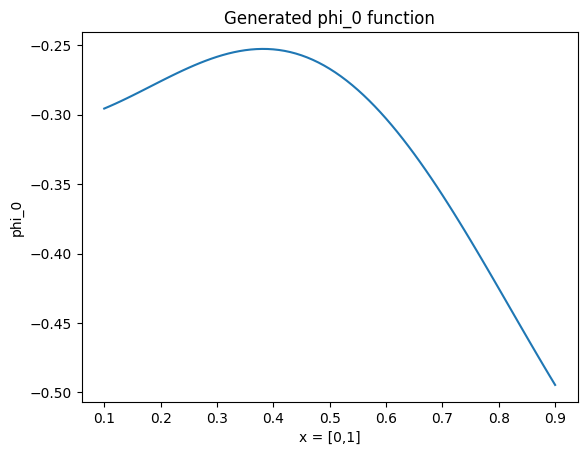

In [67]:
plt.figure()
plt.plot((x_input),tf.transpose(phi_0(x_input)))
plt.title('Generated phi_0 function')
plt.xlabel('x = [0,1]') #must use plt.xlable
plt.ylabel('phi_0') #must use plt.ylable

Text(0, 0.5, 'alpha_gauss')

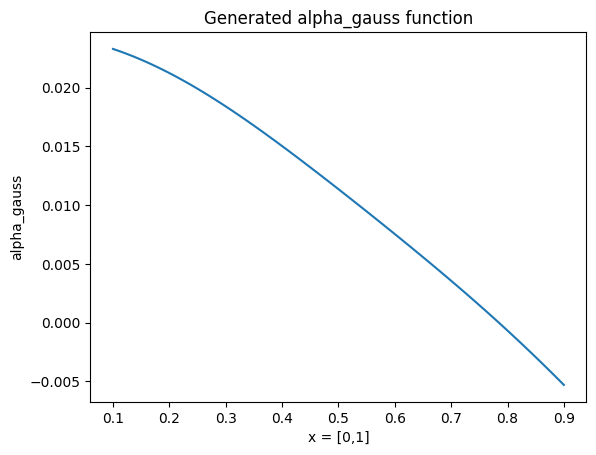

In [68]:

plt.figure()
plt.plot((x_input),tf.transpose(alpha_gauss(1, x_input)))
plt.title('Generated alpha_gauss function')
plt.xlabel('x = [0,1]')  #must use plt.xlable
plt.ylabel('alpha_gauss') #must use plt.ylable

Text(0, 0.5, 'alpha')

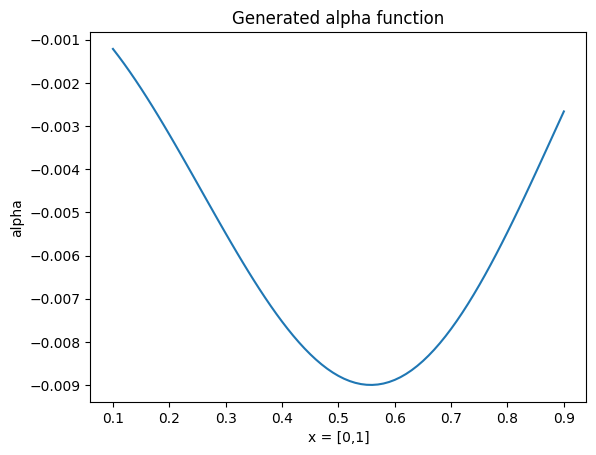

In [69]:
plt.figure()
plt.plot((x_input),tf.transpose(alpha(1, x_input)))
plt.title('Generated alpha function')
plt.xlabel('x = [0,1]')  #must use plt.xlable
plt.ylabel('alpha') #must use plt.ylable

Generate Phi_1 using Phi_0 function and alpha function. Here we are using eulers to go forwards to time 1.
We have that $\dot{x} = \alpha(x)$, so that meanst that $\int \frac{dx}{dt} = \int \alpha(x) $ which we can estimate to:

$$x(t_{k+1}) = x(t_{k}) + h_x * \alpha(x(t_{k}))$$

# creating the x_phi_1 trajectories from the true alpha in order to get phi_1. sol_alpha.y's

However, I am also storing the true alpha intermediate trajecoriest.

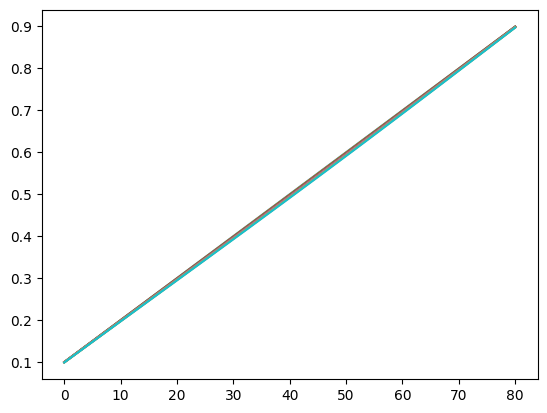

In [70]:
#sol_alpha = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
sol_alpha = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
#print(sol_test.y[:,-1])
plt.figure()
plt.plot(sol_alpha.y);

In [71]:
print(sol_alpha.y.shape)
#print(sol_test.y[:,9])
print(sol_alpha.y[:,-1].shape)

(81, 10)
(81,)


In [72]:
x_phi_1 = np.reshape(sol_alpha.y[:,-1], (len(x_input), 1))
print(x_phi_1.shape)

x_phi_1 = tf.constant(x_phi_1 )
print(x_phi_1.shape)

(81, 1)
(81, 1)


In [73]:
'''#x_input = tf.reshape(x_input, (tf.size(x_input),1))
x_phi_1 = tf.zeros((tf.size(x_input),1))
x_phi_true_traj = np.zeros((tf.size(x_input), k_x + 1))
print(x_phi_true_traj.shape)
v = x_input
x_phi_true_traj[:,0:1] = x_input
#print(x_phi_true_traj)
plt.figure() # this places a figure in begining
             # then i can plot the figures of the loops in this
for i in range(k_x+1):
    #print(i)
    plt.plot(v)
    v = v + h_x * tf.transpose(alpha(1, v))
    x_phi_true_traj[:,i+1:i+2] = v
x_phi_1 = v
#print(x_phi_1[0:10])
#print(x_input[0:10])
#print(x_phi_true_traj[:,99:100])
'''

'#x_input = tf.reshape(x_input, (tf.size(x_input),1))\nx_phi_1 = tf.zeros((tf.size(x_input),1))\nx_phi_true_traj = np.zeros((tf.size(x_input), k_x + 1))\nprint(x_phi_true_traj.shape)\nv = x_input\nx_phi_true_traj[:,0:1] = x_input\n#print(x_phi_true_traj)\nplt.figure() # this places a figure in begining\n             # then i can plot the figures of the loops in this\nfor i in range(k_x+1):\n    #print(i)\n    plt.plot(v)\n    v = v + h_x * tf.transpose(alpha(1, v))\n    x_phi_true_traj[:,i+1:i+2] = v\nx_phi_1 = v\n#print(x_phi_1[0:10])\n#print(x_input[0:10])\n#print(x_phi_true_traj[:,99:100])\n'

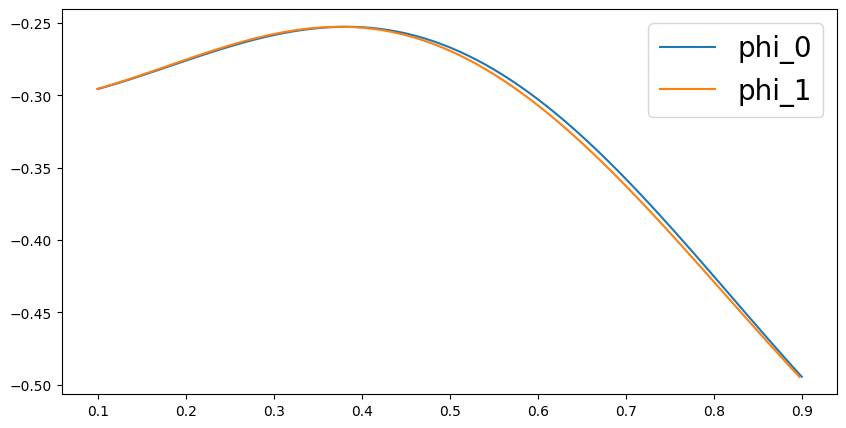

In [74]:
plt.figure(figsize=(10,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1') # this is phi_1. its the new x_input after
                                                                  # forward euler, then plot this agains
                                                                  # phi_0 true values
plt.legend(prop={'size':20});
plt.show()

## Make interplation function for phi_1

In [75]:
phi_0_fixed = phi_0(x_input)
phi_0_fixed.dtype

tf.float64

In [76]:
#x_phi_1

In [77]:
## tests
ones = tf.ones((1,10), dtype = tf.float64)
#tf.matmul(x_phi_1, ones)

In [78]:
diffOp = np.zeros((len(x_input) + 1, len(x_input)))
diffOp[1:-1, :-1] = np.eye(len(x_input)-1) #all but the last column
diffOp[1:-1, 1:] -= np.eye(len(x_input)-1) #all but the first column
diffOp[0, :-1] = diffOp[1, :-1] #first row into the zeroth rom
diffOp[-1, :] = diffOp[-2, :] # last row equals the second the last row in diffOp Added row on top and row on bot
print(diffOp) # differnce between each x if we mulipty this operator by x
# equivalent to x[:-1] - x[1:] (what's below) where x is a column vector. It's like we
# are shifting the column up and down and subtracting

[[ 1. -1.  0. ...  0.  0.  0.]
 [ 1. -1.  0. ...  0.  0.  0.]
 [ 0.  1. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1. -1.  0.]
 [ 0.  0.  0. ...  0.  1. -1.]
 [ 0.  0.  0. ...  0.  1. -1.]]


In [79]:
## create phi_1 function
# use Relu to create hat functions
# x_phi_1 as input, any x_phi _1 is zero

def phi_1(x, x_phi_1 = x_phi_1, phi_0_fixed = phi_0_fixed):
  '''
  diffOp = np.zeros((len(x_input) + 1, len(x_input)))
  diffOp[1:-1, :-1] = np.eye(len(x_input)-1) #all but the last column
  diffOp[1:-1, 1:] -= np.eye(len(x_input)-1) #all but the first column
  diffOp[0, :-1] = diffOp[1, :-1] #first row into the zeroth rom
  diffOp[-1, :] = diffOp[-2, :] # last row equals the second the last row in diffOp Added row on top and row on bot
  #print(diffOp) # differnce between each x if we mulipty this operator by x
  # equivalent to x[:-1] - x[1:] (what's below) where x is a column vector. It's like we
  # are shifting the column up and down and subtracting
  diffOp = tf.constant(diffOp, dtype = tf.float64)
  diffs = -tf.matmul(diffOp, x_phi_1)
  print(diffs.shape)
  '''
  diff_01 = np.zeros((len(x_phi_1), 1)) # is going to have two h_0s to the top
  diff_02 = np.zeros((len(x_phi_1), 1)) # is going to have h_ns to the bottom

  diff_01[1:, :] = x_phi_1[1:,:] - x_phi_1[:-1,:] #first colum of diff_01 is the differene of the shifted x_phi_1 all but the first row
  diff_01[0,0] = diff_01[1,0] # h_0, h_0, ..... h_n
  #print("diff_01")
  #print(diff_01)

  diff_02[:-1,:] = x_phi_1[1:,:] - x_phi_1[:-1,:] #:-1 is all but the last row.
  diff_02[-1, 0] = diff_02[-2, 0] # h_0, h_1,....  h_n, h_n
  #print("diff_02")
  #print(diff_02)

  diff_01 = tf.constant(diff_01, dtype = tf.float64)
  diff_02 = tf.constant(diff_02, dtype = tf.float64)

  M_diff_01 = tf.matmul(tf.ones((len(x),1),dtype=tf.float64),tf.transpose(diff_01)) #cast across columns
  M_diff_02 = tf.matmul(tf.ones((len(x),1),dtype=tf.float64),tf.transpose(diff_02)) #cast across columns
  #print("M_diff_01")
  #print(M_diff_01)
  #print("M_diff_02")
  #print(M_diff_02)
  # outproduct
  # broadcsting your x variable vector over the columns
  # then subtracting broadcasting x_phi_1 by the rows
  M = (tf.matmul(x, tf.ones((1, len(x_phi_1)), dtype = tf.float64)) - tf.matmul(tf.ones((len(x_phi_1),1), dtype = tf.float64),
                                                                               tf.transpose(x_phi_1)))
  #print("M")
  #print(M)

  hat_M = (1/M_diff_01) * tf.nn.relu(M + M_diff_01) - (1/M_diff_01 + 1/M_diff_02) * tf.nn.relu(M) + (1/M_diff_02) * tf.nn.relu(M - M_diff_02)


  #print("hat_M")
  #print(np.sum(hat_M,axis=1))
  # use

  return tf.matmul(hat_M, tf.transpose(phi_0_fixed))#h's in the picture victor drew, shoud be len(x_input) - 1 points. (distances bewteen points)


In [80]:
print(phi_0_fixed.dtype)

<dtype: 'float64'>


In [81]:
#print(x_phi_1)

In [82]:
#print(x_input)

In [83]:
phi_vec = phi_1(x_input)
print(phi_vec.shape)

(81, 1)


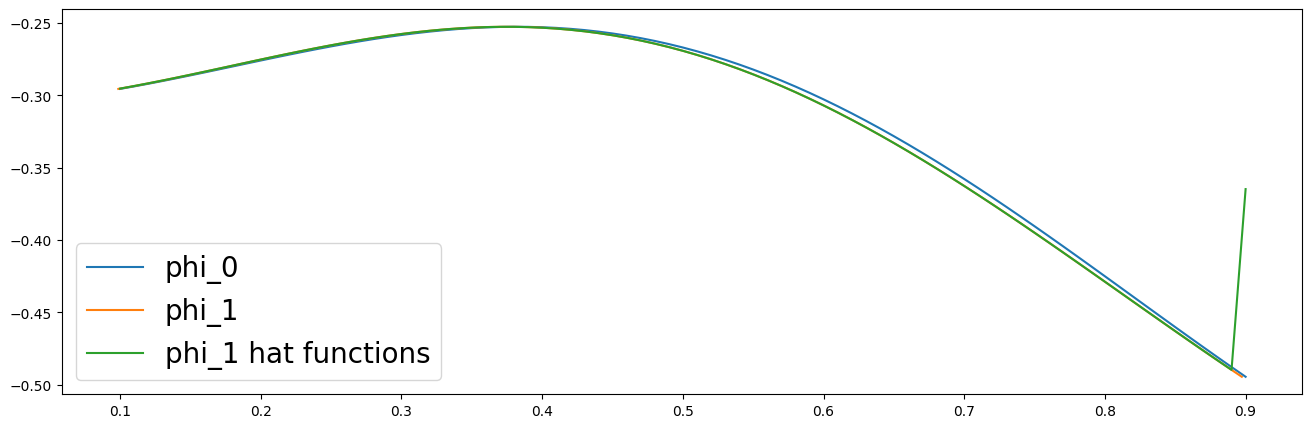

In [84]:
plt.figure(figsize=(16,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_vec, label = "phi_1 hat functions")
plt.legend(prop={'size':20});
plt.show()

## Now create a new kernel function for $\psi_0(x) = \Lambda^{1/2} U^T \psi(x)$ such that $k_0(x,y) = \psi_0(x)^T \psi_0(y)$.

This is the explicit kernel function, but with ensuring we start and end at the same place as phi_0 and phi_1.

In [85]:
'''
# new feature map to make alpha and learning alpha
def feature_map_0(x, Lambda_unitary, fourier_sample = fourier_sample_alpha,
                  feature_coeff = feature_coeff_alpha, feature_map = feature_map):
  p = feature_map(x, fourier_sample, feature_coeff)
  return tf.linalg.matmul(Lambda_unitary, p)
'''

'\n# new feature map to make alpha and learning alpha\ndef feature_map_0(x, Lambda_unitary, fourier_sample = fourier_sample_alpha,\n                  feature_coeff = feature_coeff_alpha, feature_map = feature_map):\n  p = feature_map(x, fourier_sample, feature_coeff)\n  return tf.linalg.matmul(Lambda_unitary, p)\n'

In [86]:
# normal guassian
def k9v(x,y, fourier_sample = fourier_sample_alpha,
            feature_coeff = feature_coeff_alpha,
          feature_map = feature_map):

    return tf.linalg.matmul(tf.transpose(feature_map(x, fourier_sample, feature_coeff))
                                                       , feature_map(y, fourier_sample
                                                       , feature_coeff))

(81, 81)


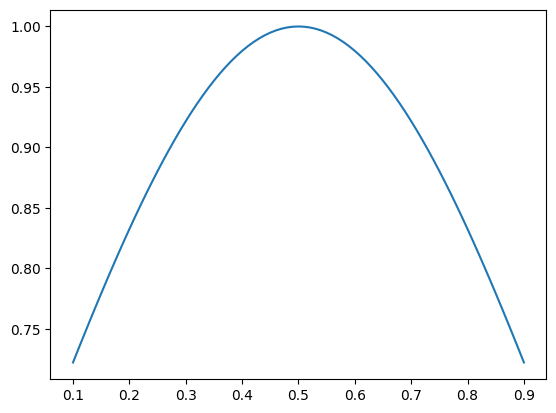

In [87]:
kern_gaus_test = k9v(x_input,x_input)
plt.plot(x_input,k9v(x_input,x_input)[40,:]);
print(kern_gaus_test.shape)

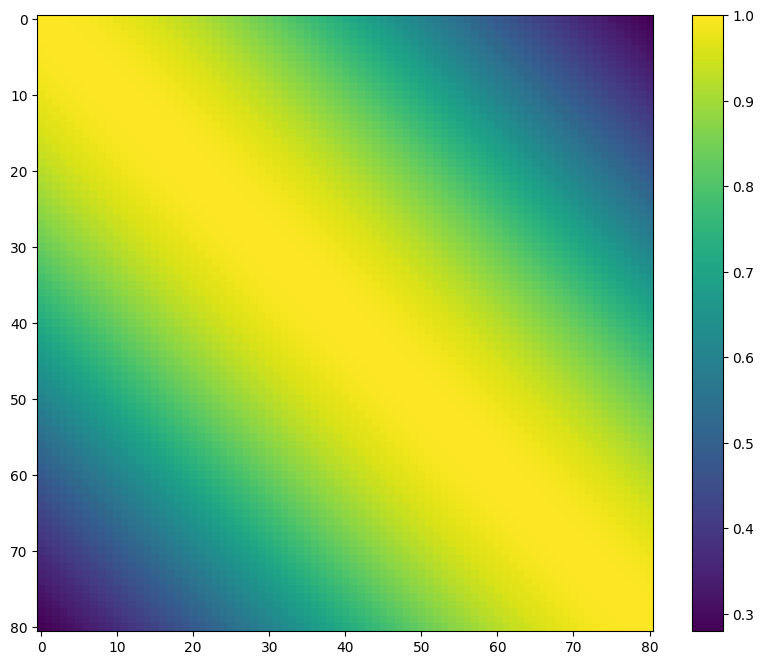

In [88]:
plt.figure(figsize = (10,8))
plt.imshow(kern_gaus_test);
plt.colorbar();

In [89]:
# Remeber, LU will be fixed the entire time, will not change since it is about
# psi(x) at the boundaries only.
def k8v(x,y, Lambda_unitary = LU, fourier_sample = fourier_sample_alpha,
                  feature_coeff = feature_coeff_alpha, feature_map = feature_map):

    return tf.linalg.matmul(tf.transpose(feature_map_0(x, Lambda_unitary, fourier_sample = fourier_sample_alpha
                                                       , feature_coeff = feature_coeff_alpha, feature_map = feature_map))
                                                       , feature_map_0(y, Lambda_unitary, fourier_sample = fourier_sample_alpha
                                                       , feature_coeff = feature_coeff_alpha, feature_map = feature_map))

In [90]:
kernel_test = k8v(x_input,x_input, LU)


In [91]:
kernel_test_2 = k8v(x_input,x_input)
kernel_test_3 = k8v(x_input, x_phi_1)
kernel_test_4 = k8v(x_01, x_01)
print(np.linalg.cond(kernel_test_3))
print(np.linalg.cond(kernel_test_2))
print(np.linalg.cond(kernel_test))
print(np.linalg.cond(kernel_test_4))

1.1565929308463823e+19
3.806256395308693e+18
3.806256395308693e+18
2.841584226887373


In [92]:
k8v(x_input,x_input).shape

TensorShape([81, 81])

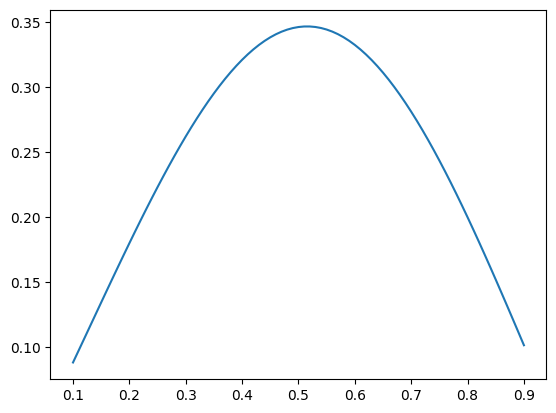

In [93]:
plt.plot(x_input,k8v(x_input,x_input)[50,:])

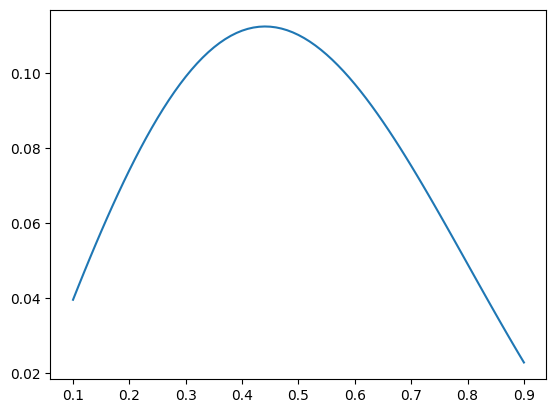

In [94]:
plt.plot(x_input,k8v(x_input,x_input)[1,:])

In [95]:
kernel_test_5 = tf.linalg.matmul(tf.transpose(feature_map(x_input, fourier_sample_alpha, feature_coeff_alpha)),feature_map(x_input, fourier_sample_alpha, feature_coeff_alpha))
print(kernel_test_5.shape)
print(np.linalg.cond(kernel_test_5))

(81, 81)
1.4681868082902077e+18


# Testing z's


In [96]:
x_05 = np.array([0.9])
# reshape x_1 into a column vector
x_05 = np.reshape(x_05, (len(x_05),1))
#print(x_01.shape)
# make numpy array into a tensorflow array
x_05 = tf.constant(x_05)

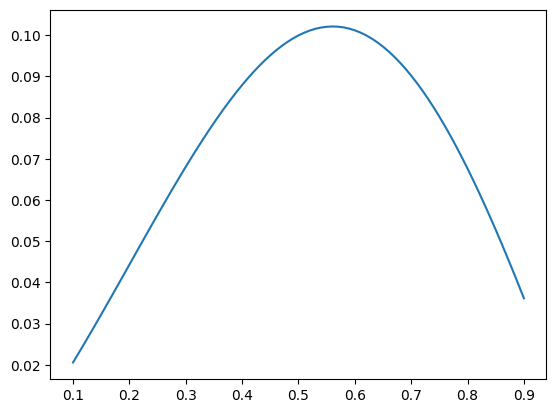

In [97]:
k8v(x_input, x_05)
plt.plot(x_input,k8v(x_input, x_05))

In [98]:
#kernel_test_7 = tf.linalg.matmul(tf.transpose(feature_map(x_input, fourier_sample_alpha, feature_coeff_alpha)),feature_map(sol.y[:,1:2], fourier_sample_alpha, feature_coeff_alpha))
#print(kernel_test_7.shape)
#print(np.linalg.cond(kernel_test_7))

In [99]:
#ker_test_6 = k8v(x_input,sol.y[:,1:2])
#print(ker_test_6.shape)
#print(np.linalg.cond(ker_test_6))

In [100]:
print(kernel_test.shape)

(81, 81)


# Make Lsk_0 and Lsk_alpha, where Lsk_0 is the LSTAR based off initial $\gamma$ constant function. Lsk_alpha uses the true trajecotires based off true alpha.

In [101]:
#this is the l_star using guassian kernel
print(L_star.shape)
print(L_star)
#l_star using explicit kernel
Lsk_0 = con(h_x, sol_1.y, num, k9v)
print(Lsk_0.shape)
print(Lsk_0)
# use sol_alpha - true trajectires using true alpha
Lsk_alpha = con(h_x, sol_alpha.y, num, k9v)
print(Lsk_alpha.shape)
print(np.linalg.cond(Lsk_alpha))

(81, 81)
[[0.00807872 0.00807832 0.00807712 ... 0.00596931 0.00592288 0.00587622]
 [0.00807832 0.00807872 0.00807832 ... 0.0060155  0.00596931 0.00592288]
 [0.00807712 0.00807832 0.00807872 ... 0.00606146 0.0060155  0.00596931]
 ...
 [0.00596931 0.0060155  0.00606146 ... 0.00807872 0.00807832 0.00807712]
 [0.00592288 0.00596931 0.0060155  ... 0.00807832 0.00807872 0.00807832]
 [0.00587622 0.00592288 0.00596931 ... 0.00807712 0.00807832 0.00807872]]
(81, 81)
[[0.00801402 0.00801242 0.00800762 ... 0.00244298 0.00237209 0.0023026 ]
 [0.00801242 0.00801402 0.00801242 ... 0.00251525 0.00244298 0.00237209]
 [0.00800762 0.00801242 0.00801402 ... 0.0025889  0.00251525 0.00244298]
 ...
 [0.00244298 0.00251525 0.0025889  ... 0.00801402 0.00801242 0.00800762]
 [0.00237209 0.00244298 0.00251525 ... 0.00801242 0.00801402 0.00801242]
 [0.0023026  0.00237209 0.00244298 ... 0.00800762 0.00801242 0.00801402]]
(81, 81)
8.586525876642555e+20


## Create a derivative function for phi_1

This was only if i didn't get the objective function to use autodif

Estimation of $\phi_1'(x)$:
$$ \phi_1'(x) = \frac{\phi_1(x+Δ) - \phi_1(x - Δ)}{2*Δ} $$
Recall that $\phi_1(x) = \phi_0(x\_phi\_1) $ for our real data. So $\phi_1(x_i(0) + \int \gamma (x_i(t)) )  = \phi_0(sol.y[:,-1])$ for the first iteration. It will be this for all iterations when we estimate $\gamma \approx \alpha$. So our derivative of $\phi_1$ will be using our $\phi_0$ function.

In [102]:
'''
# make estimate of derivative
# using central difference approximation:
# f'(x) ≈ [f(x+h) - f(x-h)]/2h
def phi_1_der(y, change): #, y make change = 1e-8, y is sol.y[:,-1]
  y = tf.constant(y, shape = (len(y), 1)) # needed to change y to a tensor in
                                          # order to put into phi_0

  return (phi_0(((y) + change)) -
          phi_0(((y) - change))) / (2*change)
'''

"\n# make estimate of derivative\n# using central difference approximation:\n# f'(x) ≈ [f(x+h) - f(x-h)]/2h\ndef phi_1_der(y, change): #, y make change = 1e-8, y is sol.y[:,-1]\n  y = tf.constant(y, shape = (len(y), 1)) # needed to change y to a tensor in\n                                          # order to put into phi_0\n\n  return (phi_0(((y) + change)) -\n          phi_0(((y) - change))) / (2*change)\n"

In [103]:
#len(sol.y[:,-1])

In [104]:
# test
#########
#row = x_input[0,:].shape
#print(row)
#print(len(x_input[0,:]))
#(phi_0((tf.constant(sol.y[:,-1], shape = (len(sol.y[:,-1]),1))) + 1e-8) - phi_0(tf.constant(sol.y[:,-1], shape = (len(sol.y[:,-1]),1)) - 1e-8)) / (2*1e-8)

In [105]:
# test
######
#phi_1_der(sol.y[:,-1], 1e-8)

In [106]:
#print(x_input.shape)
#print(x_input[0,:])
#print(sol.y[0,-1].shape)
#print(sol.y[0,-1])
#print(tf.constant(sol.y[0,-1], shape = (1,)))

## Back to algorithm: Create my objective function for gradient descent to find my first $\beta$.


We use this for our objective function gradient to solve for $\beta$ using gradient descent. We use $\gamma$ for our initial $\alpha$ and we make an initial guess for $\beta$.
\begin{align}
    \beta_{k+1} = \beta_k - \eta_k \nabla_{\beta} F(\gamma,\beta_k,\lambda)
\end{align}

\begin{align}
       & \nabla_{\beta} F(\gamma, \beta, \lambda) \notag \\
&= \frac{1}{n}\sum_{i=1}^n \begin{bmatrix}
    2 [\phi_1(x_i(0) + [L^*\beta]_i) - \phi_0(x_i(0))] \cdot [\phi_1'(x_i(0) + [L^*\beta]_i) ]\cdot  [L_{i1}]  \\
    2 [\phi_1(x_i(0) + [L^*\beta]_i) - \phi_0(x_i(0))] \cdot [\phi_1'(x_i(0) + [L^*\beta]_i) ]\cdot  [L_{i2}]  \\
        \vdots \\
    2 [\phi_1(x_i(0) + [L^*\beta]_i) - \phi_0(x_i(0))] \cdot [\phi_1'(x_i(0) + [L^*\beta]_i) ]\cdot  [L_{in}]
    \end{bmatrix} + 2\lambda L^*\beta
    \end{align}
Here we have that $x_i(0) \in \mathbb{R}$ where $i \in \lbrace 0, 1, \cdots (n-1)\rbrace$, $[L^*\beta]_i \in \mathbb{R}$, $L^* \in \mathbb{R}^{n\times n}$, $\beta \in \mathbb{R}^{n}$.

Our first
$$x_i(0) + [L^*\beta]_i = x_i(1) ≈ x_i(0) + \int \gamma(t) dt$$

We estimated $x_i(1)$ by using an ODE solver. We used the ODE solver to get the intermediate $x_i(t)$ for $t = 0,1,....,p-1 $. So we computed $L^*$.

## Initialize $\beta$

In [107]:
# Generate random numbers from a standard normal distribution
tf.random.set_seed(5);
Beta_ini = tf.random.normal(shape=(len(x_input), 1), mean=0.0, stddev=1.0, dtype = tf.float64)

#print("Beta_ini")
#print(Beta_ini.shape)

# make Beta_ini as close to zero as possible

#Beta_ini = tf.zeros(shape = (len(x_input),1), dtype = tf.float64)

print("Beta_ini")
print(Beta_ini.shape)

Beta_ini
(81, 1)


Initializing using Xavier Weight Initialization

In [108]:
# example of the xavier weight initialization
from math import sqrt
#from numpy import mean
from numpy.random import rand
# number of nodes in the previous layer
n = len(x_input) * num * 2**2 # we aren't using a NN so
                 # I am just using number of trajectories
                 # and length of x_input

# calculate the range for the weights
#lower, upper = -(1.0 / sqrt(n)), (1.0 / sqrt(n))
lower, upper = -(sqrt(6.0) / sqrt(2*n)), (sqrt(6.0) / sqrt(2*n))  # normalized Xavier
# generate random numbers
numbers = rand(len(x_input)) # the length of beta_ini
# scale to the desired range
beta_scaled = np.reshape(lower + numbers * (upper - lower), (len(x_input), 1))
# summarize
print(lower, upper)
print(beta_scaled.min(), beta_scaled.max())
print(beta_scaled.mean(), beta_scaled.std())
print(beta_scaled.shape)

-0.030429030972509225 0.030429030972509225
-0.0302817814529952 0.03013120795141398
0.0009179065225878811 0.01770188453249298
(81, 1)


In [109]:
print(L_star.dtype)
print(Lsk_alpha.dtype)
print(Lsk_0.dtype)
print(Beta_ini.dtype)

float64
float64
float64
<dtype: 'float64'>


Now compute everything for my objective function:
$$ J(\beta, \lambda)  = \frac{1}{n} \sum_{i=1}^n [\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]^2 + \lambda \beta^T L^* \beta$$

In [110]:
#lam = 1e-5 # will need to tune this
phi_0_fixed = phi_0(x_input)
print(phi_0_fixed.shape)

(1, 81)


In [111]:
len(x_input)
print(Beta_ini.shape)
print(x_input.shape)
print(phi_1(x_input).shape)

(81, 1)
(81, 1)
(81, 1)


In [112]:
def objective(Lstar, Beta_ini, lam, phi_0_fixed = phi_0_fixed, x_input = x_input):
  # L^* beta, this is a vector in R^n
  L_beta = tf.matmul(Lstar, Beta_ini)
  #print(f"Shape of L_beta: {L_beta.shape} should be a column vector")

  # phi_1 with this x_input + L^* beta
  input_ini = x_input + L_beta
  #print(f"input_ini shape: {input_ini.shape} should be colum vector")
  #print(input_ini.shape)

  # phi_1(x_i(0) + [L^*beta]_i), each i in the row vector
  # this is the interpolated phi_1 function
  phi_1_est = phi_1(input_ini)#phi_0(input_ini)
  #print(f"phi_1_est shape {phi_1_est.shape} should be column vector")
  #print(phi_1_est.shape)

  # fixed phi_0(x_input) as a vector
  ###phi_0_fixed = phi_0(x_input)
  #print(phi_0_fixed.shape)

  # take phi_1_est - phi_0_fixed then take square each component
  diff = (phi_1_est - tf.transpose(phi_0_fixed))**2
  #print(f"diff should be a column vector {diff.shape} should be a column vector")
  #print(diff.shape)

  #now sum each component, diff is a column vector
  summ_1 = tf.reduce_sum(diff, axis = 0) # i don't need axis = 0 for a column vector, but maybed later
                                          # for multidimensional inputs
  #print(f"summ_1 should be a number {summ_1.shape}")
  #print(f"this is summ_1: {summ_1}")

  #\lambda B^T L * B
  summ_2 = lam * tf.matmul(tf.transpose(Beta_ini), L_beta)
  #print(f"summ_2 is lam*B^T L* B: {summ_2.shape}")
  #print(f"this is summ_2: {summ_2}")

  # objective
  Obj = ((1 / (len(x_input))) * summ_1) + summ_2
  #print(f"objective should be a number {Obj.shape}")

  return Obj

In [113]:
objective(Lsk_0, Beta_ini, 1e-4)

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.0031458]])>

In [114]:
# testing tf.reduce_sum
'''
a = np.array([[1],[2],[3]])
print(a.shape)
a = tf.constant(a)
print(a)
a_1 = tf.reduce_sum(a, axis = 0)
print(a_1)
a_2 = tf.reduce_sum(a)
print(a_2)
'''

'\na = np.array([[1],[2],[3]])\nprint(a.shape)\na = tf.constant(a)\nprint(a)\na_1 = tf.reduce_sum(a, axis = 0)\nprint(a_1)\na_2 = tf.reduce_sum(a)\nprint(a_2)\n'

## Creating $\alpha(x)$

Now to create new alpha function with this new beta. I will then need to do ODE solver.

In [115]:
print(h_x)
print(num)
print(1/num)
print(1/(num-1))
print(sol_1.y.shape)
print(Beta_ini.shape)

0.01
10
0.1
0.1111111111111111
(81, 10)
(81, 1)


In [116]:
print(x_input.shape)
x_test = np.arange(0, 1, step =0.1)
print(x_test.shape)

(81, 1)
(10,)


In [117]:
## def Gamma(H, U, y, N): #N is num, y is sol.y, U is the open varialbe, H is h or 1/p
#print(Gamma(1/(num-1), x_test, sol.y, num)), or is h = 1/num?  why 1 / (num-1)
# because h = (b-a)/p. But p is x_0,x_1,...,x_p.  num is p + 1
# alos x_test is the input to the function, num is how many trajectoires and how many
# sumnands we have
print(Gamma(1/(num-1), x_test, sol_1.y, num, k9v).shape)

(10, 81)


In [118]:
np.dot(Gamma(1/(num-1), x_test, sol_1.y, num, k9v), Beta_ini)

array([[3.11672937],
       [3.39901039],
       [3.57363721],
       [3.6156861 ],
       [3.51227312],
       [3.26568674],
       [2.89422199],
       [2.43030589],
       [1.91608892],
       [1.39727057]])

In [119]:
print(1/(num-1))

0.1111111111111111


Gradient descent
\begin{align}
    \beta_{k+1} = \beta_k - \eta_k \nabla_{\beta} F(\gamma,\beta_k,\lambda)
\end{align}

In [120]:
'''
for i in range(100):


  Beta_ini = tf.Variable(Beta_ini)
  with tf.GradientTape() as tape:
      tape.watch(Beta_ini)
      obj = objective(L_star, Beta_ini)
  if  i % 10 == 0:
    print(i)
    print(obj)

  beta_grad = tape.gradient(obj, Beta_ini) # this is taking the gradient

  Beta_ini = Beta_ini - eta * beta_grad   # gradient desecnt

'''
#print(beta_grad)  #

'\nfor i in range(100):\n\n\n  Beta_ini = tf.Variable(Beta_ini)\n  with tf.GradientTape() as tape:\n      tape.watch(Beta_ini)\n      obj = objective(L_star, Beta_ini)\n  if  i % 10 == 0:\n    print(i)\n    print(obj)\n\n  beta_grad = tape.gradient(obj, Beta_ini) # this is taking the gradient\n\n  Beta_ini = Beta_ini - eta * beta_grad   # gradient desecnt\n\n'

In [121]:
#print(Beta_ini)
#print(Beta_ini.shape)

In [122]:
# a test run for autodiff from tensorflow
x = tf.constant(2.0)
with tf.GradientTape() as tape:
    tape.watch(x)
    y = x**2 + 3*x + 1

dy_dx = tape.gradient(y, x)
print(dy_dx)  # Output: tf.Tensor(7.0, shape=(), dtype=float32)

tf.Tensor(7.0, shape=(), dtype=float32)


Test this out:

In [123]:
sol_1.y

array([[0.1       , 0.11951833, 0.13903665, 0.15855498, 0.1780733 ,
        0.19759163, 0.21710995, 0.23662828, 0.2561466 , 0.27566493],
       [0.11      , 0.12951833, 0.14903665, 0.16855498, 0.1880733 ,
        0.20759163, 0.22710995, 0.24662828, 0.2661466 , 0.28566493],
       [0.12      , 0.13951833, 0.15903665, 0.17855498, 0.1980733 ,
        0.21759163, 0.23710995, 0.25662828, 0.2761466 , 0.29566493],
       [0.13      , 0.14951833, 0.16903665, 0.18855498, 0.2080733 ,
        0.22759163, 0.24710995, 0.26662828, 0.2861466 , 0.30566493],
       [0.14      , 0.15951833, 0.17903665, 0.19855498, 0.2180733 ,
        0.23759163, 0.25710995, 0.27662828, 0.2961466 , 0.31566493],
       [0.15      , 0.16951833, 0.18903665, 0.20855498, 0.2280733 ,
        0.24759163, 0.26710995, 0.28662828, 0.3061466 , 0.32566493],
       [0.16      , 0.17951833, 0.19903665, 0.21855498, 0.2380733 ,
        0.25759163, 0.27710995, 0.29662828, 0.3161466 , 0.33566493],
       [0.17      , 0.18951833, 0.2090366

In [124]:
def new_a(u, y, kern = k9v, num = num, h=(1/(num-1)), Beta_ini = Beta_ini):
  return np.dot(Gamma(1/(num-1), u, y, num, kern), Beta_ini)

In [125]:
new_a(x_test, sol_1.y)

array([[3.11672937],
       [3.39901039],
       [3.57363721],
       [3.6156861 ],
       [3.51227312],
       [3.26568674],
       [2.89422199],
       [2.43030589],
       [1.91608892],
       [1.39727057]])

Test alpha with arguments not defined. I will need this when doing the cross validation.

In [126]:
#def new_a_2(t, u, y, num, beta, h = (1/(num-1))):#, Beta_ini = Beta_ini):
#  return np.dot(Gamma(1/(num-1), u, y, num), beta)

In [127]:
#new_a_2(1, x_test, sol.y, num, Beta_ini)

In [128]:
# just to compare the new_alpha and original function
#def alpha(x,theta = theta2, fourier_sample = fourier_sample_alpha, feature_coeff = feature_coeff_alpha):
#    return gen_func_1(x, theta, fourier_sample = fourier_sample, feature_coeff = feature_coeff) # gen_func_1 usies LU, here we placed feature_map_alpha to ensure we have 0 on bounderies

In [129]:
def new_alpha(t, u, kern, y, num, beta, h = (1/(num-1))):
  return np.dot(Gamma(h, u, y, num, kern), beta)

In [130]:
#Gamma(H, U, y, N, kern)

In [131]:
first_iter = new_alpha(1, np.reshape(x_input,(len(x_input))), k9v, sol_1.y, num, Beta_ini)

In [132]:
#test_alpha = new_alpha(1, np.reshape(x_input,(len(x_input))), k8v, sol.y, num, theta2)

(1, 81)


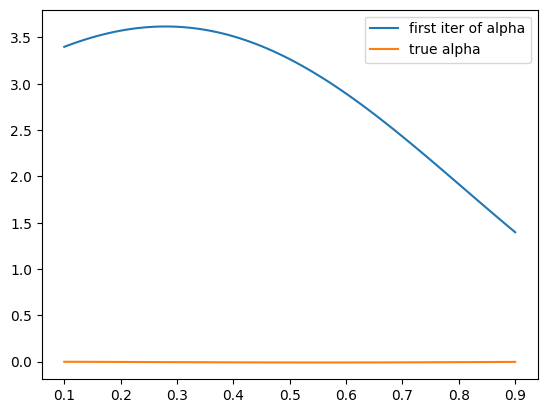

In [133]:
plt.plot(x_input, first_iter, label = 'first iter of alpha')
plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'true alpha')
print(alph(1, x_input).shape)
plt.legend();

I will need to make my function with a t in it in order to use the ODE integrator

## Make ODE for $\alpha$

For the ODE solver remember that the initial condition must be (n,) shape and since my output of the new_alpha can be a vector, I must put the variable vectorized = True.

Additionally, I did a test with a function new_a_2. Here we could use alpha and put arguments in the ODE function.  

In [134]:
#sol_new_a_2 = solve_ivp(new_a_2,[0,1],np.reshape(x_test,len(x_test)), t_eval=t_list, vectorized = True, args=(sol.y, num, Beta_ini))

In [135]:
#sol_new_a_2.y

In [136]:
# projection of guassian kernel
#sol_alpha_test = solve_ivp(new_alpha,[0,1],np.reshape(x_test, len(x_test)),t_eval=t_list, vectorized = True, args=(k8v, sol_1.y, num, Beta_ini))
# new alpha using guassian kernel
sol_alpha_test = solve_ivp(new_alpha,[0,1],np.reshape(x_test, len(x_test)),
                           t_eval=t_list, vectorized = True,
                           args=(k9v, sol_1.y, num, Beta_ini))

In [137]:
sol_alpha_test.y

array([[0.        , 0.38649861, 0.71903606, 0.91645726, 1.02962198,
        1.09572   , 1.14396861, 1.17678875, 1.20048917, 1.21854681],
       [0.1       , 0.49143283, 0.78522693, 0.95355918, 1.05212468,
        1.111921  , 1.15500763, 1.18483562, 1.20656881, 1.22311736],
       [0.2       , 0.58118225, 0.83805054, 0.98304448, 1.0703639 ,
        1.12490458, 1.16398366, 1.19140372, 1.21152846, 1.22686549],
       [0.3       , 0.65887886, 0.8822642 , 1.00806692, 1.08612189,
        1.13605085, 1.17178174, 1.19713453, 1.21586038, 1.23015369],
       [0.4       , 0.72763871, 0.92100132, 1.03085322, 1.10071736,
        1.14635359, 1.17906597, 1.20251225, 1.21993314, 1.23325753],
       [0.5       , 0.79019093, 0.95639576, 1.0525256 , 1.11483468,
        1.15633233, 1.18619146, 1.2077985 , 1.22394669, 1.23632801],
       [0.6       , 0.84883599, 0.99005087, 1.07377189, 1.12891308,
        1.16632555, 1.19339716, 1.21317243, 1.22803932, 1.23947107],
       [0.7       , 0.90554383, 1.0233162

In [138]:
# guassian k9v
sol_alpha = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                      t_eval=t_list, vectorized = True,
                      args=(k9v, sol_1.y, num, Beta_ini))

In [139]:
sol_alpha.y.shape

(81, 10)

## Cross validation using k-folds:

In [140]:
# function to split data into kfolds

#def splitdata(u, kfold):
#    return np.array_split(u, kfold)

In [141]:
#new_alpha(t, u, y, num, Beta_ini, h = (1/(num-1)))
#new_alpha(1, np.array([0]), sol.y, num, Beta_ini)

In [142]:
#phi_0_fixed.shape
#phi_1_fixed = phi_0(x_phi_1)
#print(phi_1_fixed.shape)

In [143]:
'''
n = len(x_input)
kfolds = 10 #number of kfolds
m = 15 # number of lambdas
lambs = np.logspace(-12,-4, num = m, base =10)
#lambs = np.linspace(400,600, num = m)
eta = 0.01


# Main for loop

D = splitdata(x_input, kfolds)   #x_input split into kfolds
D_y = splitdata(x_phi_1, kfolds) #x_phi_1 split into kfolds
phi_1_split = splitdata(tf.transpose(phi_1_fixed.numpy()), kfolds) # fixed phi_0 data split into kfolds
vv = np.zeros((m,1))                #initialized v vector
# using same initialized beta before it goes into while loop

for j in range(kfolds):
    #print(j)
    for l in range(m):
      #print(l)

      # Get first iteration of Beta to use for cross-validation
      # for each lambda
      for ii in range(10):
        Beta_ini = tf.Variable(Beta_ini)
        #print(Beta_ini)
        with tf.GradientTape() as tape:
          tape.watch(Beta_ini)
          obj = objective(L_star, Beta_ini, lambs[l])
        #print(lambs[l])
        beta_grad = tape.gradient(obj, Beta_ini) # this is taking the gradient
        Beta_new = Beta_ini - eta * beta_grad   # gradient desecnt
      #print(Beta_new)
      B = splitdata(Beta_new, kfolds)

      # testing data
      X_test = D[j]             # Selecting jth fold for data test
      #print(f"This is the shape of X_test: {X_test.shape}")
      Y_test = D_y[j]           # Selecting jth fold for target test
      #print(f"This is the shape of Y_test: {Y_test.shape}")
      phi_1_test = phi_1_split[j]
      #print(f"This is the shape of phi_o_test: {phi_0_test.shape}")
      Beta_test = B[j]

      # 'train' data
      X_train = np.reshape(np.delete(D, j, axis=0), ((n - int(n/kfolds)),1))   # Removing the data test and keeping the remaining data for training
      #print(f"This is the shape of X_train: {X_train.shape}")
      Y_train = np.reshape(np.delete(D_y, j, axis =0), ((n - int(n/kfolds)),1))# Removing the test target and keeping the rest for training
      #print(f"This is the shape of Y_train: {Y_train.shape}")
      Beta_train = np.reshape(np.delete(B, j, axis=0), ((n - int(n/kfolds)),1))  # I still need to make sure if i need to do this or not
                                                                                  # but my betas are depended on my l_star size
      #print(f"Beta_ini train: {Beta_ini_split_train.shape}")

      # obtain the data from the ODE gamma for just the X_train data which would be
      # approximating phi_1 at time 1
      sol_split_1 = solve_ivp(f, [0,1], np.reshape(X_train, len(X_train)), t_eval = t_list)
      #print(f"This is the shape of sol_split: {sol_split_1.y.shape}")

      # now use this sol_split to obtain L* data just for X_train data
      #L_star_split = con(h_x, sol_split_1.y, num)
      #print(f"L_star_split shpae: {L_star_split.shape}")

      # now conduct ODE for alpha_new based on the t_train arguments using X_test
      # this should give me a vector of len(Tx_test) by 1 because i'm integrating to t = 1 only
      sol_alpha_test = solve_ivp(new_alpha,[0,1],np.reshape(X_test,len(X_test)),t_eval=[1], vectorized = True, args=(sol_split_1.y, num, Beta_train))
      #print(sol_alpha_test.y.shape)
      #print(phi_0_test.shape)

      # now subtract sol_alpha_test.y - phi_0(test), then square the vector column sum this will be my v[l] error
      difference = (sol_alpha_test.y - phi_1_test)**2
      #print(difference)
      vv[l] = np.sum(difference, axis = 0)

print(vv)

 '''


'\nn = len(x_input)\nkfolds = 10 #number of kfolds\nm = 15 # number of lambdas\nlambs = np.logspace(-12,-4, num = m, base =10)\n#lambs = np.linspace(400,600, num = m)\neta = 0.01\n\n\n# Main for loop\n\nD = splitdata(x_input, kfolds)   #x_input split into kfolds\nD_y = splitdata(x_phi_1, kfolds) #x_phi_1 split into kfolds\nphi_1_split = splitdata(tf.transpose(phi_1_fixed.numpy()), kfolds) # fixed phi_0 data split into kfolds\nvv = np.zeros((m,1))                #initialized v vector\n# using same initialized beta before it goes into while loop\n\nfor j in range(kfolds):\n    #print(j)\n    for l in range(m):\n      #print(l)\n\n      # Get first iteration of Beta to use for cross-validation\n      # for each lambda\n      for ii in range(10):\n        Beta_ini = tf.Variable(Beta_ini)\n        #print(Beta_ini)\n        with tf.GradientTape() as tape:\n          tape.watch(Beta_ini)\n          obj = objective(L_star, Beta_ini, lambs[l])\n        #print(lambs[l])\n        beta_grad = tape

In [144]:
#print(lambs)

In [145]:
#lambda_index = np.argmin(vv)
#print(lambda_index)
#print(lambs[lambda_index])


In [146]:
'''
plt.figure(figsize=(16,8));
plt.plot(lambs,vv,label='U-Shape Curves of error')
plt.scatter(lambs,vv,color='r');
plt.legend(prop={'size':20});
plt.xlabel('Lambdas', fontsize=18)
plt.ylabel('Error', fontsize=16)
plt.show()
'''

"\nplt.figure(figsize=(16,8));\nplt.plot(lambs,vv,label='U-Shape Curves of error')\nplt.scatter(lambs,vv,color='r');\nplt.legend(prop={'size':20});\nplt.xlabel('Lambdas', fontsize=18)\nplt.ylabel('Error', fontsize=16)\nplt.show()\n"

## Make while loop.


This was just for starting the algorithm. Now make new L_start with trajectories

In [147]:
#L_star_iter = con(h_x, sol_alpha.y, num)

Now use this L* and Beta_init for the gradient descent

# testing gradient descent

In [148]:
eta = 1e-1
LAM = 1e-4 #lambs[lambda_index] #1e-6
Beta = Beta_ini
#Sol.y = sol.y
LSTAR = L_star

#def objective(L_star, Beta_ini, lam, phi_0_fixed = phi_0_fixed, x_input = x_input):

for i in range(10):


  Beta = tf.Variable(Beta)
  with tf.GradientTape() as tape:
      tape.watch(Beta)
      obj = objective(LSTAR, Beta, LAM)
  if  i % 1 == 0:
    print(i)
    print(obj)

  beta_grad = tape.gradient(obj, Beta) # this is taking the gradient

  Beta = Beta - eta * beta_grad   # gradient desecnt

0
tf.Tensor([[0.00633085]], shape=(1, 1), dtype=float64)
1
tf.Tensor([[0.00631884]], shape=(1, 1), dtype=float64)
2
tf.Tensor([[0.00630743]], shape=(1, 1), dtype=float64)
3
tf.Tensor([[0.00629659]], shape=(1, 1), dtype=float64)
4
tf.Tensor([[0.00628629]], shape=(1, 1), dtype=float64)
5
tf.Tensor([[0.0062765]], shape=(1, 1), dtype=float64)
6
tf.Tensor([[0.00626721]], shape=(1, 1), dtype=float64)
7
tf.Tensor([[0.00625838]], shape=(1, 1), dtype=float64)
8
tf.Tensor([[0.00624999]], shape=(1, 1), dtype=float64)
9
tf.Tensor([[0.00624202]], shape=(1, 1), dtype=float64)


In [149]:
'''
# I used this to help me start my while loop
for i in range(100):


  Beta_ini = tf.Variable(Beta_ini)
  with tf.GradientTape() as tape:
      tape.watch(Beta_ini)
      obj = objective(L_star_iter, Beta_ini)
  if  i % 10 == 0:
    print(i)
    print(obj)

  beta_grad = tape.gradient(obj, Beta_ini) # this is taking the gradient

  Beta_ini = Beta_ini - eta * beta_grad   # gradient desecnt
  '''

'\n# I used this to help me start my while loop\nfor i in range(100):\n\n\n  Beta_ini = tf.Variable(Beta_ini)\n  with tf.GradientTape() as tape:\n      tape.watch(Beta_ini)\n      obj = objective(L_star_iter, Beta_ini)\n  if  i % 10 == 0:\n    print(i)\n    print(obj)\n\n  beta_grad = tape.gradient(obj, Beta_ini) # this is taking the gradient\n\n  Beta_ini = Beta_ini - eta * beta_grad   # gradient desecnt\n  '

Now, make $\alpha$ with this

1.   new Beta_ini
2.   sol_alpha.y ???



In [150]:
#sec_iter = new_alpha(1, np.reshape(x_input,(len(x_input))), y = sol_alpha.y)#, num = num, h = (1/(num-1)), Beta_ini = Beta_ini)

In [151]:
#plt.plot(x_input, first_iter)
#plt.plot(x_input, sec_iter)
#plt.plot(x_input, np.transpose(alpha(x_input)))

In [152]:
'''
# using alpha to get input for phi_0 to estimate phi_1
#x_input = tf.reshape(x_input, (tf.size(x_input),1))
x_phi_new = tf.zeros((tf.size(x_input),1))
v = x_input
plt.figure() # this places a figure in begining
             # then i can plot the figures of the loops in this
for i in range(k_x):
    #plt.plot(v)
    v = v + h_x * new_alpha(1, np.reshape(v,(len(v))), y = sol_alpha.y, num = num, h = (1/(num-1)), Beta_ini = Beta_ini)
x_phi_new = v
'''


'\n# using alpha to get input for phi_0 to estimate phi_1\n#x_input = tf.reshape(x_input, (tf.size(x_input),1))\nx_phi_new = tf.zeros((tf.size(x_input),1))\nv = x_input\nplt.figure() # this places a figure in begining\n             # then i can plot the figures of the loops in this\nfor i in range(k_x):\n    #plt.plot(v)\n    v = v + h_x * new_alpha(1, np.reshape(v,(len(v))), y = sol_alpha.y, num = num, h = (1/(num-1)), Beta_ini = Beta_ini)\nx_phi_new = v\n'

In [153]:
#plt.figure(figsize=(10,5))
#plt.plot(x_input, np.transpose(phi_0_fixed), label ='phi_0')
#plt.plot(x_input,np.transpose(phi_0(x_phi_1)), label = 'phi_1')
#plt.plot(x_input,np.transpose(phi_0(x_phi_new )), label = "phi_1_est")
#plt.legend(prop={'size':20});
#plt.show()

## While loop

At this point I have:

1.   1st Lsk_0 (lstar) from $\gamma$ ODE solver
2.   I have x_input
3.   I have phi_0_fixed = phi_0(x_input)
4.   Now I need to start gradient descent and using initial $\beta$. So keep using this. $\beta$




In [154]:
'''
# already initialized. not going to initilaze again
# Generate random numbers from a standard normal distribution
Beta_ini = tf.random.normal(shape=(len(x_input), 1), mean=0.0, stddev=1.0, dtype = tf.float64)

print("Beta_ini")
print(Beta_ini.shape)
'''

'\n# already initialized. not going to initilaze again\n# Generate random numbers from a standard normal distribution\nBeta_ini = tf.random.normal(shape=(len(x_input), 1), mean=0.0, stddev=1.0, dtype = tf.float64)\n\nprint("Beta_ini")\nprint(Beta_ini.shape)\n'

In [155]:
#diff[:15]

In [156]:
#print(sol_1.y.shape)
#print(Lsk_0.shape)

In [157]:
## generate a function that checks my objective function is decreasing
#1. i need to store the function outputs
#2. compare the one from the other.
#3. returen False or Ture
#4. remember to put this in to while loop after i have two things
# in the list to actually compare

def decreasing(results):
  for i in range(1, len(results)):
      if results[i] > results[i - 1]:
        return False, print(f"The obj values started Increasing at index {i}: {results[i-1]} -> {results[i]}")


  return True, print('The obj function is NOT increasing')



In [158]:
# Example usage:
my_list = [5, 4, 3, 2, 1, 1]

decreasing(my_list)
#    print("The items in the list are decreasing.")
#else:
#    print("The items in the list are not decreasing.")

The obj function is NOT increasing


(True, None)

In [159]:
2**5 * 1e-3

0.032

In [160]:
'''#simple but working
#get start time
eta = ((2**5)/(2**0)) * 1e-3 #(2**5) * 1e-3
print(f"This is the first eta: {eta}")
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
var_2 = 0
LAM = (10**0) * 1e-6 #lambs[lambda_index] #1e-6
Beta = Beta_ini
#sol = sol_1.y
LSTAR =  Lsk_0
OBJ = [] #put the results in this list to compare the elements for GD
OBJ_2 = [] #lstar obj restulst

##initialize the firts sol.y
sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)
##initial the first sol_alpha.y's with true trajecotires.
#sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(16,5))

cond = True
cond_2 = True

while(cond):

  mm += 1
  #print(mm)

  # Gradient Desecent
  for i in range(3):
  #while(cond_2):

    Beta = tf.Variable(Beta)
    with tf.GradientTape() as tape:
        tape.watch(Beta)
        obj = objective(LSTAR, Beta, LAM)
        obj_1 = obj.numpy() #make obj into a numpy
        OBJ.append(float(obj_1)) #make numpy into a float


    # Check the modulo condition
    var += 1
    if var % 10 == 0:
        #print(var)
        print(f"Here is the obj value for GD: {obj}")
        print("Is GD obj decrease?")
        print(decreasing(OBJ))

        if decreasing(OBJ)[0] == False:
          print(f"This is the iteration where we stopped: {mm}")
          cond = False #stop algorithm
        #print("This is the value I'm looking for:" , {diff[mm]})

    # Increment the value
    #var += 1
'''
'''
    if  i % 50 == 0:
      print(i)
      print(obj)
'''


'''
    beta_grad = tape.gradient(obj, Beta) # this is taking the gradient
    print(np.sum(beta_grad**2))

    Beta = Beta - eta * beta_grad   # gradient desecn

    #print(f"GD Obj values: {OBJ}")
    #print(f"GD obj: {float(obj_1)}")
    # error
    beta_vector[:,mm:mm+1] = Beta

    if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

      diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ L_star
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )
      #print("This should be the same: ", {diff[mm]})


    #if mm % 4 == 0:  #if m modulo constant occurs, print m
    #    rem = mm
    #    print('Iteration count: ' +str(rem))
    #    print('Convergence using norm of RKHS at '+str(rem) +'iterations: ' +str(diff[mm]))
    #    print('Beta norm error: '+str(diff[mm]))
'''
'''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False


'''

'''

  # ODEvsolver. Put arguments for sol.y and num in here
  #'''
'''
  if mm == 25:
    print('Here is were we change the eta, i think we need an epoch loop')
    print(mm)
'''
'''
  sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k8v, sol.y, num, Beta))

  plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k8v,
                            y = sol.y,
                            num = num,
                            beta= Beta))#, label = 'new_a')
  #'''
'''
  # test out original alpha
  #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

  #Make new L_star with ODE solver data
  LSTAR = con(h_x, sol.y, num, k8v)


  #if mm % 50 == 0:
  obj_2 = objective(LSTAR, Beta, LAM)
  obj_2 = obj_2.numpy() #make obj into a numpy
  OBJ_2.append(float(obj_2)) #make numpy into a float

  var_2 += 1
  if var_2 % 10 == 0:
    print(f"Here is the obj value for LSTAR: {obj_2}")
    print("Is LSTAR obj decrease?")
    print(decreasing(OBJ_2))
    if decreasing(OBJ_2)[0] == False:
      print(f"This is the iteration where we stopped: {mm}")
      cond = False

  #print(f"LSTAR change objective: {OBJ_2}")
  #print(f"LSTAR obj: {float(obj_2)}")
  # after gradient descent we should still decrease objective
  # compare to the last gradeint desecent objective print
  # compare the LSTAR
  # plot this
  #print(obj)

  if mm == 10:
    print(mm)
    print(f"Here is the objective function results at the end {objective(LSTAR, Beta, LAM)}")
    cond = False # stop algorithm

plt.plot(x_input, np.transpose(alpha(1, x_input)), label = 'alpha original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#print("GD obj list: ")
#print(decreasing(OBJ))
#print("LSTAR obj list:")
#print(decreasing(OBJ_2))
'''


'\n  # test out original alpha\n  #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)\n\n  #Make new L_star with ODE solver data\n  LSTAR = con(h_x, sol.y, num, k8v)\n\n\n  #if mm % 50 == 0:\n  obj_2 = objective(LSTAR, Beta, LAM)\n  obj_2 = obj_2.numpy() #make obj into a numpy\n  OBJ_2.append(float(obj_2)) #make numpy into a float\n\n  var_2 += 1\n  if var_2 % 10 == 0:\n    print(f"Here is the obj value for LSTAR: {obj_2}")\n    print("Is LSTAR obj decrease?")\n    print(decreasing(OBJ_2))\n    if decreasing(OBJ_2)[0] == False:\n      print(f"This is the iteration where we stopped: {mm}")\n      cond = False\n\n  #print(f"LSTAR change objective: {OBJ_2}")\n  #print(f"LSTAR obj: {float(obj_2)}")\n  # after gradient descent we should still decrease objective\n  # compare to the last gradeint desecent objective print\n  # compare the LSTAR\n  # plot this\n  #print(obj)\n\n  if mm == 10:\n    print(mm)\n    print(f"Here is the objective func

## Find a close $\beta$:

Obtain true trajectories for true $\alpha(x)$. I did this by conducting sol_ivp for $\alpha$, then using my integral function called Gamma. Gamma outputs an $(n \times m$) matrix.  One column for each m input (each x input we provide gives a new vector).

Create $\alpha(x)$. Below is our quadrature for $\alpha$. Again $p$ is the number of intermediate trajectories we choose and $h = 1/(p-1)$.  Recall $\alpha(x) = \sum_{k=1}^n \beta_k L^*_{x_{k}}(x)$, where $L^*_{x_{k}}(x) = \int K(x, x_k(s))dt$.
\begin{align}
    &\int_0^1  K(x, x_k(s)) ds \notag \\
    &\approx \frac{h}{2} K(x, x_k(s_0)) + h  \sum_{i=1}^{p-1} K(x, x_k(s_i)) + \frac{h}{2}  K(x, x_k(s_p))
\end{align}
We use the trapezoid composite rule where $k \in \lbrace 1, \dots, n\rbrace$ and $i \in \lbrace 0,\dots, p-1 \rbrace$ for our function $\alpha$.

If dim$(x) = m$ or $(m,1)$,  $L^*_{x}(x) \in m \times n$.

## I created the alpha function using the projection kernel, alpha, and I created a alpha_gauss function uisng the guassian kernel. I created vector from .1 to .9 with increments of .01. My condition number is way smaller thatn e+31, but it is still quite large. e+18.

In [161]:
# remember, this alpha uses the projection kernel for the kernel
# this now uses k9v for kernel which is the guassian for alpha
sol = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
# uses the projection kernel for alpha
# sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

L_x = Gamma(1/(num-1), np.reshape(x_input, (len(x_input))), y = sol.y, N = num, kern = k9v)
print(sol.y.shape)
print(L_x.shape)
print(np.linalg.cond(L_x))

(81, 10)
(81, 81)
5.99382359384622e+18


Here is my true alpha vector with input of $x\_input$. This is a $(101 \times 1)$ vector. I am solving:

\begin{align*}
 \alpha(x(0)) & = L^*_x(x(0)) \beta\\
 \Rightarrow  & L^*_x(x(0))^{-1} \alpha(x(0)) = \beta
 \end{align*}

 I calculated a $beta$ by np.linalg.solve(L_x,alpha_0).

In [162]:
#alpha_0 = alpha(1, x_input) #x_input is x(0)
alpha_0 = alph(1, x_input)
alpha_0 = alpha_0.numpy()
print(alpha_0.T.shape)
L_x_inv = np.linalg.inv(L_x)
#print(np.linalg.cond(L_x))
beta_star_1 = L_x_inv @ alpha_0.T

(81, 1)


pseduo inverse for LSTAR. I needed to flip the arrays since eigh provides eigenvalues is ascending order.

In [163]:
#U, S, Vh = np.linalg.svd(L_x, full_matrices= False)

In [164]:
#print(S.shape)
#print(Vh.shape)
#print(U.shape)

In [165]:
'''eig, eigvec = LA.eigh(L_x)
#print(eig[:10]) # assending order
eig = np.reshape(eig, (len(eig),1))
#print(eigvec.shape)
eig_true = np.flip(eig)
#print(eig_true[:10])
eigvec_true = np.flip(eigvec,1)
#print(eigvec[:,-1]) #these correspond.  I need to flip them
#print(eigvec_true[:,0])
'''

'eig, eigvec = LA.eigh(L_x)\n#print(eig[:10]) # assending order\neig = np.reshape(eig, (len(eig),1))\n#print(eigvec.shape)\neig_true = np.flip(eig)\n#print(eig_true[:10])\neigvec_true = np.flip(eigvec,1)\n#print(eigvec[:,-1]) #these correspond.  I need to flip them\n#print(eigvec_true[:,0])\n'

In [166]:
#np.linalg.norm(U @ np.diag(S) @ Vh - L_x)


In [167]:
#L_x_pseudo = np.transpose(Vh) @ np.diag(1/np.reshape(S, (len(S)))) @ np.transpose(U) #Vh is already transposed

In [168]:
#np.linalg.norm(L_x_inv - L_x_pseudo)

In [169]:
alpha_0.T.shape

(81, 1)

In [170]:
#L_x_pseudo.shape

In [171]:
#beta_star_2 = L_x_pseudo @ alpha_0.T

In [172]:
beta_star_3 = np.linalg.solve(L_x, alpha_0.T)

In [173]:
np.linalg.norm(L_x @ beta_star_3 - alpha_0.T)/np.linalg.norm(alpha_0.T)

1.9242780381264278e-08

In [174]:
eig, eigvec = np.linalg.eig(L_x)


# condition number of L_x

In [175]:
print(np.linalg.cond(L_x))

5.99382359384622e+18


In [176]:
print(eig)

[ 6.72894481e+01+0.00000000e+00j  1.24719824e+01+0.00000000e+00j
  1.16889554e+00+0.00000000e+00j  6.49891397e-02+0.00000000e+00j
  2.25026550e-03+0.00000000e+00j  5.00383070e-05+0.00000000e+00j
  6.64106027e-07+0.00000000e+00j  6.00599613e-09+0.00000000e+00j
  3.47016030e-11+0.00000000e+00j  1.47266819e-13+0.00000000e+00j
  1.88364583e-15+0.00000000e+00j -2.12652305e-17+1.29381586e-15j
 -2.12652305e-17-1.29381586e-15j  1.09137537e-15+0.00000000e+00j
 -9.18774449e-16+0.00000000e+00j -6.53055857e-16+5.62039271e-16j
 -6.53055857e-16-5.62039271e-16j  8.83596584e-16+2.79625052e-16j
  8.83596584e-16-2.79625052e-16j -5.12201404e-17+8.00168707e-16j
 -5.12201404e-17-8.00168707e-16j -7.06635534e-16+3.34116546e-16j
 -7.06635534e-16-3.34116546e-16j  8.28703779e-16+3.38697754e-16j
  8.28703779e-16-3.38697754e-16j  7.94073302e-16+0.00000000e+00j
  4.95255756e-16+6.70130530e-16j  4.95255756e-16-6.70130530e-16j
 -7.02610661e-16+2.16933670e-16j -7.02610661e-16-2.16933670e-16j
  3.02755968e-16+7.302283

In [177]:
# input beta_star_3 into new_alpha
# k9v instead of k8v
newalpha_0 = new_alpha(1, np.reshape(x_input,(len(x_input))), kern = k9v, y = sol.y, num = num, beta = beta_star_3)
#def new_alpha(t, u, kern, y, num, beta, h = (1/(num-1)))

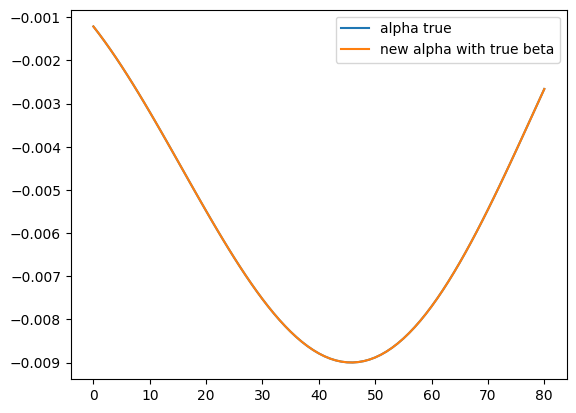

In [178]:
plt.plot(alpha_0.T, label = 'alpha true')
plt.plot(newalpha_0, label = 'new alpha with true beta');
plt.legend();
#'''

Now, let's consider the objective function and see if $[\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]$ is close to zero.
$$ J(\beta, \lambda)  = \frac{1}{n} \sum_{i=1}^n [\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]^2 + \lambda \beta^T L^* \beta$$

this is from the objective function with beta_star_2: [[1.32073736e-07]]
(81, 1)
tf.Tensor([[1.32073736e-07]], shape=(1, 1), dtype=float64)
(81, 1)
error norm: 8.709541138008978e-09
loss function test: [[1.32073736e-07]]
loss function with beta_star_2: f[[1.32073736e-07]]


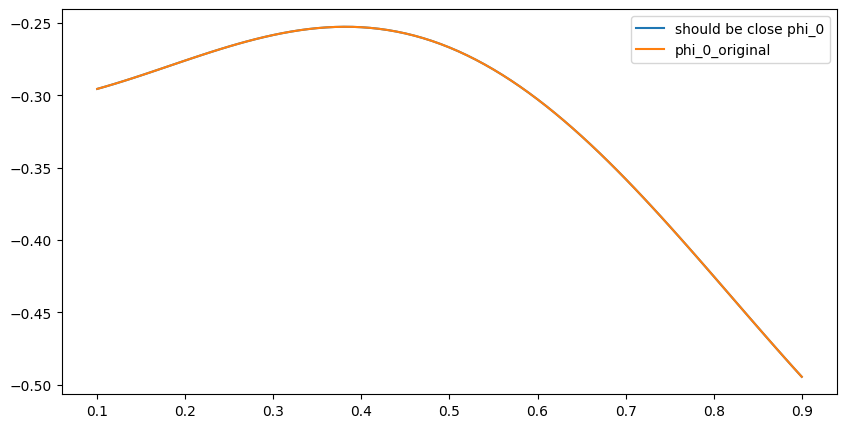

In [179]:
# let's look at objective function with TRUE trajectories:
# Our goal is to show that phi_1(x(1)) ~ phi_0(X(0)), i.e. our outputs should
# equal for phi_1 and phi_0. Using our objection function, I calculted phi_1(x(0) + LB). This
# should be very close to phi_0(X(0)).


LAM = 10**2 * 1e-6

# theta3 is used for alpha.
# solve.y uses our true x trajectoires
# this LSTAR uses true x trajectories to solve for obj function
# use k9v
LSTAR = con(1/(num-1), y = sol.y, num = num, kern = k9v)

print(f"this is from the objective function with beta_star_2: {objective(LSTAR, beta_star_3, LAM)}")

########
#Test out objective function
########
LB = tf.matmul(LSTAR, beta_star_3) #Beta_ini)
#print(LB)
print(LB.shape)
BTLB = tf.matmul(tf.transpose(beta_star_3), LB) #tf.matmul(tf.transpose(Beta_ini), LB)
print(LAM * BTLB)

############
input = x_input + LB
print(input.shape)
phi_1_est = phi_1(input)
error = (phi_1_est - tf.transpose(phi_0_fixed))**2
print(f'error norm: {np.linalg.norm(phi_1_est - tf.transpose(phi_0_fixed))/np.linalg.norm(tf.transpose(phi_0_fixed))}')
summ_1 = tf.reduce_sum(error, axis = 0)
loss_test = ((1 / (len(x_input)) ) * summ_1) + LAM * BTLB
print(f'loss function test: {loss_test}')
print(f'loss function with beta_star_2: f{objective(LSTAR, beta_star_3, LAM)}')

plt.figure(figsize=(10,5))
#plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1_original')

# these values should be close, regardless of what they are being plotted against.
plt.plot(x_input, phi_1_est, label = 'should be close phi_0');
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0_original')


plt.legend();

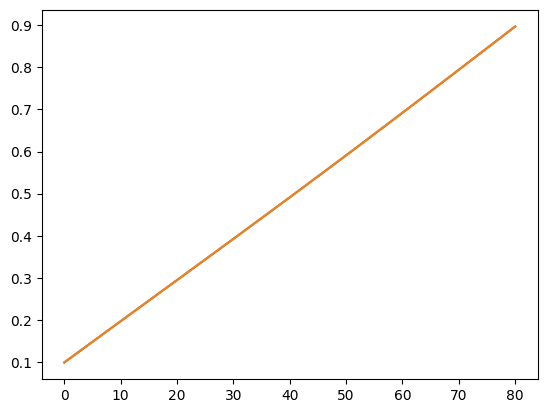

In [180]:
plt.plot(input) #input = x(0) + LB_i
plt.plot(sol.y[:,-1]);

## While loop testing => use this for close $\beta$

obj_old with Beta: [[1.32073736e-09]]
1
Here is the objective function results at 1 iterations: [[0.00640253]]
the value of eta: 0.00390625
tf.Tensor([[1.32073736e-09]], shape=(1, 1), dtype=float64)
2.0739309787750244


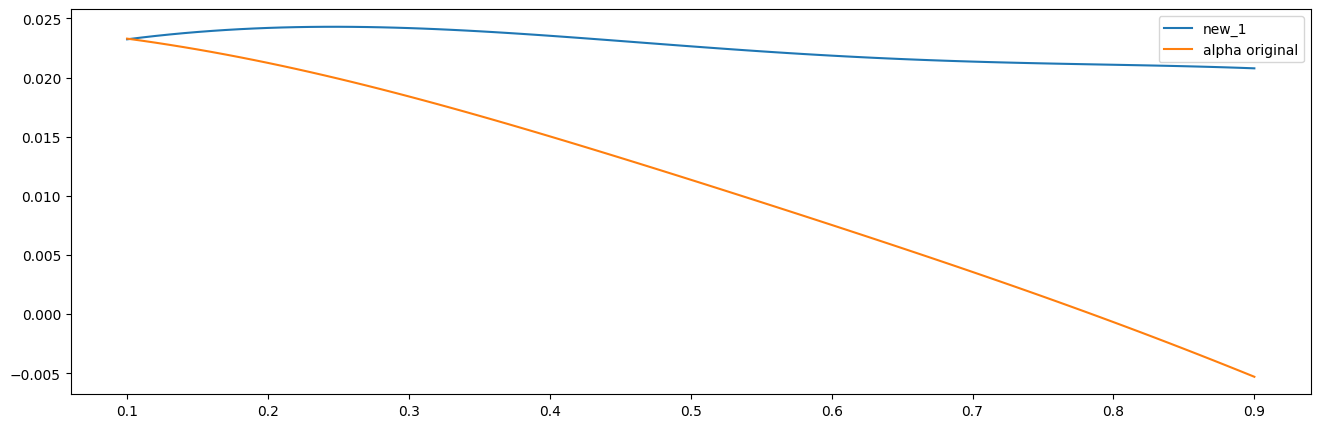

In [181]:
#TEST
#get start time
#eta = ((2**5)/(2**1)) * 1e-3 #(2**5) * 1e-3
#print(f"This is the first eta: {eta}")
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
var_2 = 0
LAM = (10**0) * 1e-6 #lambs[lambda_index] #1e-6
Beta = beta_star_3 #Beta_ini
#sol = sol_1.y
#LSTAR = Lsk_alpha #Lsk_alpha# Lsk_alpha is with true trajectories, Lsk_0
OBJ = [] #put the results in this list to compare the elements for GD
OBJ_2 = [] #lstar obj restulst

#initialize the firts sol.y
#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)
##initial the first sol_alpha.y's with true trajecotires.
# sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
sol = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
# k9v

LSTAR = con(1/(num-1), y = sol.y, num = num, kern = k9v)

# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(16,5))

cond = True
cond_2 = True

while(cond):


    mm += 1
    #print(mm)

    # Gradient Desecent
    for i in range(1):
    #while(cond_2):
      eta = 1 / (2**8)#2.5 * (1e-4)#3**1 * 1e-2 #.01
      #sol_alpha = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
      #Lsk_alpha = con(h_x, sol_alpha.y, num, k8v) #Lsk_alpha is with true trajectories,
      ##print(f"eta initialized {eta}")

      Beta = tf.Variable(Beta)
      with tf.GradientTape() as tape:
          tape.watch(Beta)
          #print(Beta)


      # Check the modulo condition
      #var += 1
      #if var % 10 == 0:
          #print(var)
          #print(f"Here is the obj value for GD: {obj}")
      #print("Is GD obj decrease?")
      #print(decreasing(OBJ))
          obj = objective(LSTAR, Beta, LAM)
          print(f"obj_old with Beta: {obj}")
          #print(f"This is gradient {i}th iteration obj_old: {obj}")


      beta_grad = tape.gradient(obj, Beta) # this is taking the gradient
      #print(np.linalg.norm(beta_grad))
      #print(beta_grad)
      #print(np.sum(beta_grad**2))

      Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad)) # gradient desecn
      #Beta = Beta - eta * beta_grad

      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) #-1
      #make new obj
      obj_new = objective(LSTAR, Beta, LAM)
      #print(f"obj_new with Beta after GD: {obj_new}")

      '''
      #kamel's test
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) - 1
      #OBJ.append(float(obj_1)) #make numpy into a float
      '''
      '''
      #if decreasing(OBJ)[0] == False:
      while obj_new > obj_old: #obj_1 > obj_old:
        print("obj is increasing")
        #obj_old = np.copy(obj_1)

        print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
        #print(f"GD: print the var variable {var}")
        #cond = False #stop algorithm
        eta = eta / 2
        print(f"Eta changed: {eta}")
        Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
        #Beta = Beta - eta * beta_grad
        obj_new = objective(LSTAR, Beta, LAM)
        #obj_1 = obj.numpy() #make obj into a numpy
        #obj_old = np.copy(obj_1)
        # do GD
      '''
        #then recheck that decreasing(OBJ)[0] == True
            #print(f"objection funcion is increasing, change eta to: {eta}")
        #print("This is the value I'm looking for:" , {diff[mm]})

      # Increment the value
      #var += 1

      '''
      if  i % 50 == 0:
        print(i)
        print(obj)
      '''







      #print(f"GD Obj values: {OBJ}")
      #print(f"GD obj: {float(obj_1)}")
      # error
      beta_vector[:,mm:mm+1] = Beta

      if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

        diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ L_star
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )
      #print("This should be the same: ", {diff[mm]})


    #if mm % 4 == 0:  #if m modulo constant occurs, print m
    #    rem = mm
    #    print('Iteration count: ' +str(rem))
    #    print('Convergence using norm of RKHS at '+str(rem) +'iterations: ' +str(diff[mm]))
    #    print('Beta norm error: '+str(diff[mm]))
    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''

  # ODEvsolver. Put arguments for sol.y and num in here
  #'''
    #if mm % 15 == 0:
    #  print('Here is were we change the eta, i think we need an epoch loop')
    #  print(mm)

    #sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
    #              t_eval=t_list,
    #              vectorized = True,
    #              args=(k8v, sol.y, num, Beta))

  #'''

  # test out original alpha
    #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

    #plt.plot(x_input, np.transpose(alpha(1, x_input)), label = f"new_{mm}")
    #k9v
    plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y, #keep true traj
                            num = num,
                            beta= Beta), label = f'new_{mm}')


  #Make new L_star with ODE solver data
    # removed so we can use original Lsk_alpha which is the same thing if we use
    # sol_ivp for true alpha
    #LSTAR = con(h_x, sol.y, num, k8v)


    #if mm % 50 == 0:
    #obj_2 = objective(LSTAR, Beta, LAM)
    #obj_2 = obj_2.numpy() #make obj into a numpy
    #OBJ_2.append(float(obj_2)) #make numpy into a float

    #var_2 += 1
    #if var_2 % 10 == 0:
    #print(f"Here is the obj value for LSTAR: {obj_2}")
    #print("Is LSTAR obj decrease?")
    #print(decreasing(OBJ_2))
    #if decreasing(OBJ_2)[0] == False:
    #  print(f"LSTAR: This is the iteration where we stopped: {mm}")
    #  cond = False

        #eta = eta / 2
        #print(f"objection funcion is increasing, change eta to: {eta}")

  #print(f"LSTAR change objective: {OBJ_2}")
  #print(f"LSTAR obj: {float(obj_2)}")
  # after gradient descent we should still decrease objective
  # compare to the last gradeint desecent objective print
  # compare the LSTAR
  # plot this
  #print(obj)

    if mm % 1 == 0:
      print(mm)
      print(f"Here is the objective function results at {mm} iterations: {objective(LSTAR, Beta, LAM)}")
      print(f"the value of eta: {eta}")
      cond = False # stop algorithm
      #if decreasing(OBJ)[0] and decreasing(OBJ_2)[0] == True:
      #  eta = eta / 2
#        print(f"this is the same eta: {eta}")
#      else:
#        eta = eta / 2
#        print(f"objection funcion is increasing, change eta to: {eta}")

plt.plot(x_input, np.transpose(alpha_gauss(1, x_input)), label = 'alpha original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#print("GD obj list: ")
#print(decreasing(OBJ))
#print("LSTAR obj list:")
#print(decreasing(OBJ_2))


In [182]:
print(np.linalg.norm(beta_star_3 - Beta) / np.linalg.norm(beta_star_3))
#plt.plot(x_input, beta_star_2, label = 'Beta using original alpha and L_x pseduo invers')
#plt.plot(x_input, Beta, label = 'GD Beta')
#plt.legend();

5.942448115278121e-09


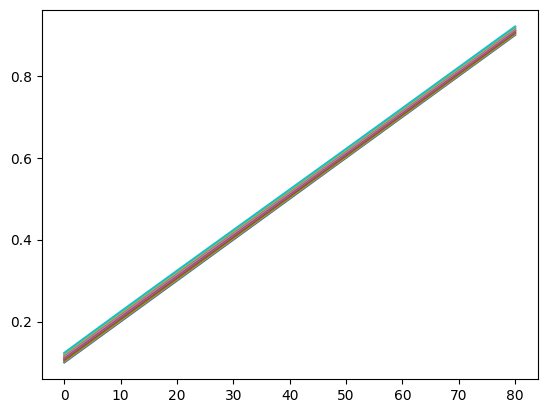

In [183]:
# sol - true trajectoires, how x changes based on integrating with alpha
# k9v
solve_Beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

plt.plot(solve_Beta.y);

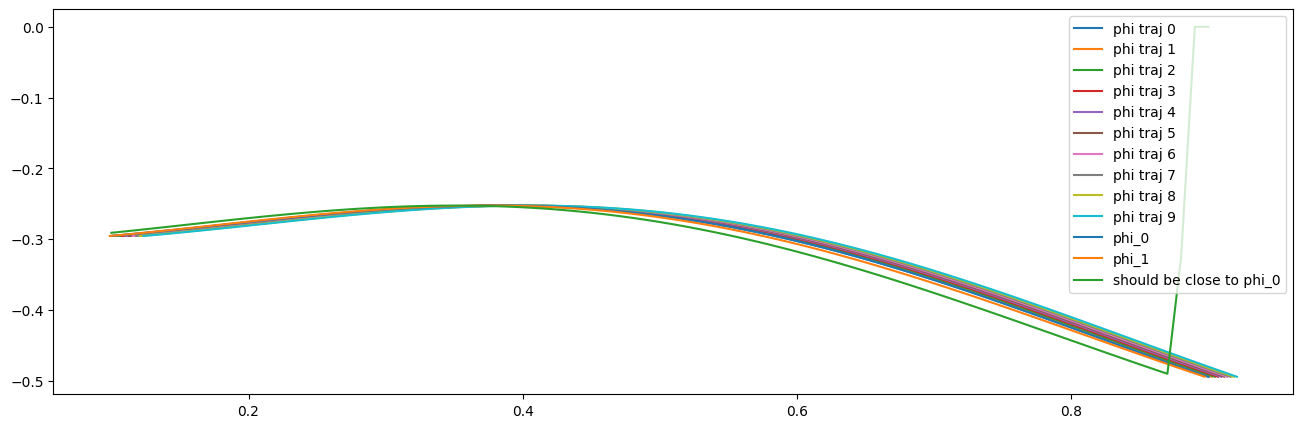

In [184]:
plt.figure(figsize=(16,5))
for i in range(len(solve_Beta.y[0])):
  plt.plot(solve_Beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (len(x_input),1))), label = 'should be close to phi_0')
plt.legend();

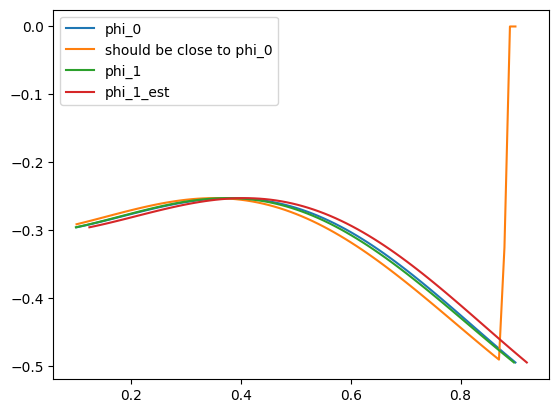

In [185]:
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (len(x_input),1))), label = 'should be close to phi_0');
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(np.reshape(solve_Beta.y[:,-1], (len(x_input),1)), np.transpose(phi_0(x_input)), label = 'phi_1_est')

plt.legend();

## Infor on phi_0 and phi_ 1like DTW

In [186]:
print(alpha_0.T[:10])

[[-0.00121189]
 [-0.00138182]
 [-0.00155921]
 [-0.00174365]
 [-0.0019347 ]
 [-0.00213193]
 [-0.00233486]
 [-0.00254302]
 [-0.00275592]
 [-0.00297305]]


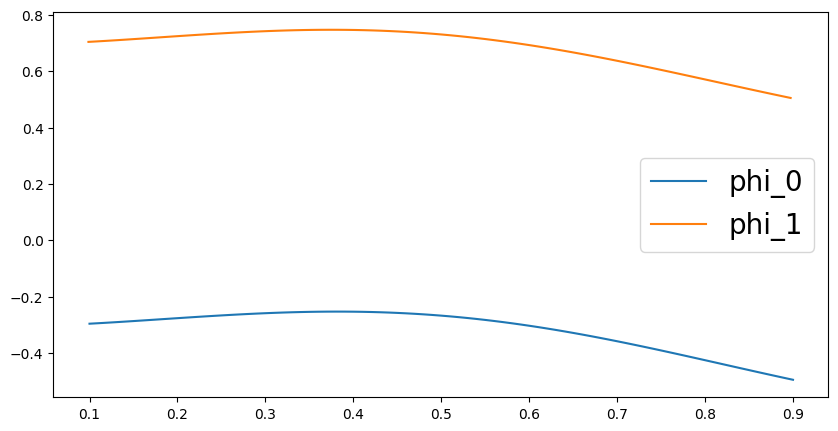

In [187]:
plt.figure(figsize=(10,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
offset = 1

plt.plot(x_phi_1, np.transpose(phi_0(x_input)) + offset, label = 'phi_1')
plt.legend(prop={'size':20});
plt.show()

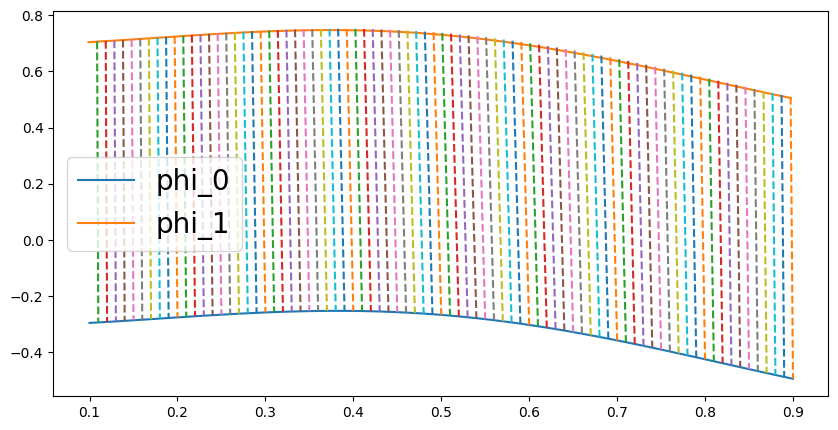

'\n#import matplotlib.pyplot as plt\npt = (0.01,-0.38773961)\nslope = -5.43027049e-03\npt_1 = (0.02,-0.44777292)\nslope_1 = -1.08374759e-02\n#pt = (3, 4)\n#slope = -2\n# Given the above, calculate y intercept "b" in y=mx+b\nb_1 = pt[1] - slope * pt[0]\nb_2 = pt_1[1] - slope * pt_1[0]\n\n# Now draw two points around the input point\npt1 = (pt[0] - (5.81163294e-03), slope * (pt[0] - (-0.4930057  )) + b_1 + offset)\npt2 = (pt_1[0]- (1.16230087e-02), slope * (pt_1[0] - (-0.59172036)) + b_2 + offset)\n\n# Draw two line segments around the input point\nplt.plot((pt1[0], pt[0]), (pt1[1], pt[1]),linestyle=\'--\')\nplt.plot((pt_1[0], pt2[0]), (pt_1[1], pt2[1]),  linestyle=\'dashed\')\n\n\nplt.plot()\nplt.legend(prop={\'size\':20});\nplt.show()\n'

In [188]:
plt.figure(figsize=(10,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
offset = 1

plt.plot(x_phi_1, np.transpose(phi_0(x_input)) + offset, label = 'phi_1') # this is phi_1. its the new x_input after
                                                                  # forward euler, then plot this agains

for i in range(1, len(alpha_0.T)):
  pt = (x_input.numpy()[i], np.transpose(phi_0(x_input))[i])
  slope = alpha_0.T[i]
  b = pt[1] - slope * pt[0]
  pt1 = (x_phi_1[i], slope * (np.transpose(phi_0(x_input))[i]) + b + offset)
  plt.plot((pt1[0], pt[0]), (pt1[1], pt[1]),linestyle='--')

plt.plot()
plt.legend(prop={'size':20});
plt.show();

'''
#import matplotlib.pyplot as plt
pt = (0.01,-0.38773961)
slope = -5.43027049e-03
pt_1 = (0.02,-0.44777292)
slope_1 = -1.08374759e-02
#pt = (3, 4)
#slope = -2
# Given the above, calculate y intercept "b" in y=mx+b
b_1 = pt[1] - slope * pt[0]
b_2 = pt_1[1] - slope * pt_1[0]

# Now draw two points around the input point
pt1 = (pt[0] - (5.81163294e-03), slope * (pt[0] - (-0.4930057  )) + b_1 + offset)
pt2 = (pt_1[0]- (1.16230087e-02), slope * (pt_1[0] - (-0.59172036)) + b_2 + offset)

# Draw two line segments around the input point
plt.plot((pt1[0], pt[0]), (pt1[1], pt[1]),linestyle='--')
plt.plot((pt_1[0], pt2[0]), (pt_1[1], pt2[1]),  linestyle='dashed')


plt.plot()
plt.legend(prop={'size':20});
plt.show()
'''

In [189]:
#blah = dtw(phi_1(x_input), np.transpose(phi_0(x_input)), keep_internals=True,
#    step_pattern=rabinerJuangStepPattern(6, "c"))\
#    .plot(type="twoway",offset=-2);

## Add noise to Beta_Star

In [190]:
percent_error = 1*np.exp(-50)
n_3 = np.linalg.norm(beta_star_3)

1.267857782261852e-16
[[ 2.09018413e-17]
 [ 1.06690646e-18]
 [ 2.34405860e-18]
 [-9.74620838e-19]
 [-2.70051691e-17]
 [ 1.94930474e-18]
 [-2.02258733e-17]
 [ 2.84436601e-18]
 [-7.52093039e-18]
 [ 1.46123141e-17]]
                   0
count      81.000000
mean       -0.000152
std     73493.620490
min   -147991.109856
25%    -59758.492326
50%     -9890.239581
75%     51907.975600
max    158360.812813
                   0
count      81.000000
mean       -0.000152
std     73493.620490
min   -147991.109856
25%    -59758.492326
50%     -9890.239581
75%     51907.975600
max    158360.812813


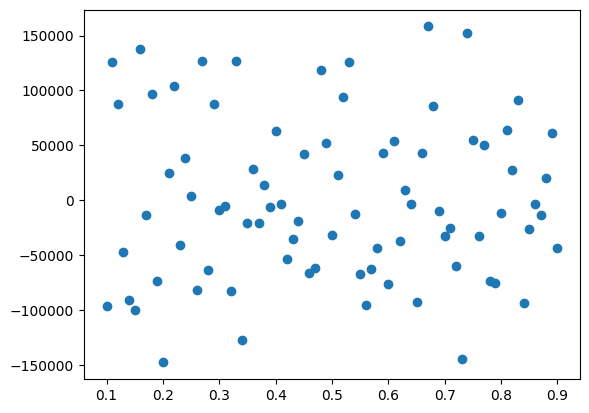

In [191]:
np.random.seed(14)
mu, sigma = 0, .03 # mean and standard deviation
s = np.random.normal(mu, sigma, size=(len(x_input),1))
s = s * (n_3 / np.linalg.norm(s)) * percent_error
print(np.linalg.norm(s))
print(s[0:10,:])
beta_noise = s + beta_star_3
#plt.plot(beta_star_3);
plt.scatter(x_input, beta_star_3);
df_describe = pd.DataFrame(beta_star_3)
print(df_describe.describe())
df_describe_noise = pd.DataFrame(beta_noise)
print(df_describe_noise.describe())

                   0
count      79.000000
mean     1778.886510
std     73431.849025
min   -147991.109856
25%    -56808.338908
50%     -9144.337339
75%     53024.737560
max    158360.812813


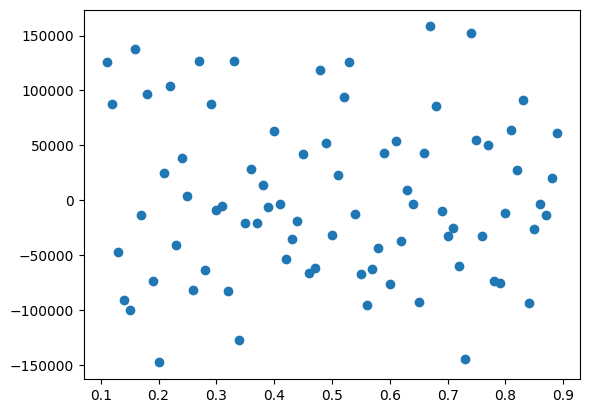

In [192]:
beta_star_elimnate= beta_star_3[1:-1]
df_describe_eli = pd.DataFrame(beta_star_elimnate)
x_eli = x_input[1:-1]
print(df_describe_eli.describe())
plt.scatter(x_eli, beta_star_elimnate)

1
obj_old with Beta: [[1.32073736e-06]]
1
Here is the objective function results at 1 iterations: [[1.32073736e-06]]
the value of eta: 9.332636185032189e-302
tf.Tensor([[1.32073736e-06]], shape=(1, 1), dtype=float64)
1.2322595119476318


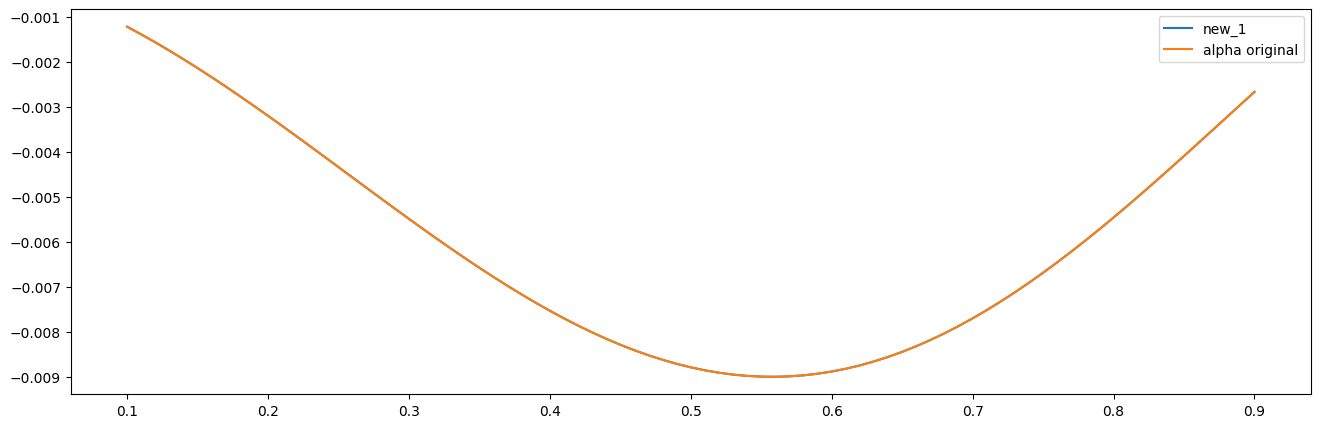

In [193]:
#TEST
#get start time
#eta = ((2**5)/(2**1)) * 1e-3 #(2**5) * 1e-3
#print(f"This is the first eta: {eta}")
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
var_2 = 0
LAM = (10**0) * 1e-3 #lambs[lambda_index] #1e-6
Beta = beta_noise#beta_star_3 #Beta_ini
#sol = sol_1.y
#LSTAR = Lsk_alpha #Lsk_alpha# Lsk_alpha is with true trajectories, Lsk_0
OBJ = [] #put the results in this list to compare the elements for GD
OBJ_2 = [] #lstar obj restulst

#initialize the firts sol.y
#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)
##initial the first sol_alpha.y's with true trajecotires.
sol = solve_ivp(alph,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

newalpha_0 = new_alpha(1, np.reshape(x_input,(len(x_input))), kern = k9v, y = sol.y, num = num, beta = beta_star_3)

#sol_noise = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
#                t_eval=t_list,
#                vectorized = True,
#                args=(k9v, sol.y, num, beta_noise))

#def new_alpha(t, u, kern, y, num, beta, h = (1/(num-1)))
LSTAR = con(1/(num-1), y = sol.y, num = num, kern = k9v)

# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(16,5))

cond = True
cond_2 = True

while(cond):


    mm += 1
    print(mm)

    # Gradient Desecent
    for i in range(1):
    #while(cond_2):
      eta = 1 / (2**1000)#2.5 * (1e-4)#3**1 * 1e-2 #.01
      #sol_alpha = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)
      #Lsk_alpha = con(h_x, sol_alpha.y, num, k8v) #Lsk_alpha is with true trajectories,
      ##print(f"eta initialized {eta}")

      Beta = tf.Variable(Beta)
      with tf.GradientTape() as tape:
          tape.watch(Beta)
          obj = objective(LSTAR, Beta, LAM)
          print(f"obj_old with Beta: {obj}")
          #print(f"This is gradient {i}th iteration obj_old: {obj}")


      beta_grad = tape.gradient(obj, Beta) # this is taking the gradient
      #print(np.linalg.norm(beta_grad))
      #print(beta_grad)
      #print(np.sum(beta_grad**2))

      Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad)) # gradient desecn
      #Beta = Beta - eta * beta_grad

      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) #-1
      #make new obj
      obj_new = objective(LSTAR, Beta, LAM)
      #print(f"obj_new with Beta after GD: {obj_new}")

      '''
      #kamel's test
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) - 1
      #OBJ.append(float(obj_1)) #make numpy into a float
      '''
      '''
      #if decreasing(OBJ)[0] == False:
      while obj_new > obj_old: #obj_1 > obj_old:
        print("obj is increasing")
        #obj_old = np.copy(obj_1)

        print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
        #print(f"GD: print the var variable {var}")
        #cond = False #stop algorithm
        eta = eta / 2
        print(f"Eta changed: {eta}")
        Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
        #Beta = Beta - eta * beta_grad
        obj_new = objective(LSTAR, Beta, LAM)
        #obj_1 = obj.numpy() #make obj into a numpy
        #obj_old = np.copy(obj_1)
        # do GD
      '''
        #then recheck that decreasing(OBJ)[0] == True
            #print(f"objection funcion is increasing, change eta to: {eta}")
        #print("This is the value I'm looking for:" , {diff[mm]})

      # Increment the value
      #var += 1

      '''
      if  i % 50 == 0:
        print(i)
        print(obj)
      '''







      #print(f"GD Obj values: {OBJ}")
      #print(f"GD obj: {float(obj_1)}")
      # error
      beta_vector[:,mm:mm+1] = Beta

      if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

        diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ L_star
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )
      #print("This should be the same: ", {diff[mm]})


    #if mm % 4 == 0:  #if m modulo constant occurs, print m
    #    rem = mm
    #    print('Iteration count: ' +str(rem))
    #    print('Convergence using norm of RKHS at '+str(rem) +'iterations: ' +str(diff[mm]))
    #    print('Beta norm error: '+str(diff[mm]))
    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''

  # ODEvsolver. Put arguments for sol.y and num in here
  #'''
    #if mm % 15 == 0:
    #  print('Here is were we change the eta, i think we need an epoch loop')
    #  print(mm)

    #sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
    #              t_eval=t_list,
    #              vectorized = True,
    #              args=(k8v, sol.y, num, Beta))

  #'''

  # test out original alpha
    #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

    #plt.plot(x_input, np.transpose(alpha(1, x_input)), label = f"new_{mm}")

    plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y, #keep true traj
                            num = num,
                            beta= Beta), label = f'new_{mm}')


  #Make new L_star with ODE solver data
    # removed so we can use original Lsk_alpha which is the same thing if we use
    # sol_ivp for true alpha
    #LSTAR = con(h_x, sol.y, num, k8v)


    #if mm % 50 == 0:
    #obj_2 = objective(LSTAR, Beta, LAM)
    #obj_2 = obj_2.numpy() #make obj into a numpy
    #OBJ_2.append(float(obj_2)) #make numpy into a float

    #var_2 += 1
    #if var_2 % 10 == 0:
    #print(f"Here is the obj value for LSTAR: {obj_2}")
    #print("Is LSTAR obj decrease?")
    #print(decreasing(OBJ_2))
    #if decreasing(OBJ_2)[0] == False:
    #  print(f"LSTAR: This is the iteration where we stopped: {mm}")
    #  cond = False

        #eta = eta / 2
        #print(f"objection funcion is increasing, change eta to: {eta}")

  #print(f"LSTAR change objective: {OBJ_2}")
  #print(f"LSTAR obj: {float(obj_2)}")
  # after gradient descent we should still decrease objective
  # compare to the last gradeint desecent objective print
  # compare the LSTAR
  # plot this
  #print(obj)

    if mm % 1 == 0:
      print(mm)
      print(f"Here is the objective function results at {mm} iterations: {objective(LSTAR, Beta, LAM)}")
      print(f"the value of eta: {eta}")
      cond = False # stop algorithm
      #if decreasing(OBJ)[0] and decreasing(OBJ_2)[0] == True:
      #  eta = eta / 2
#        print(f"this is the same eta: {eta}")
#      else:
#        eta = eta / 2
#        print(f"objection funcion is increasing, change eta to: {eta}")

plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#print("GD obj list: ")
#print(decreasing(OBJ))
#print("LSTAR obj list:")
#print(decreasing(OBJ_2))


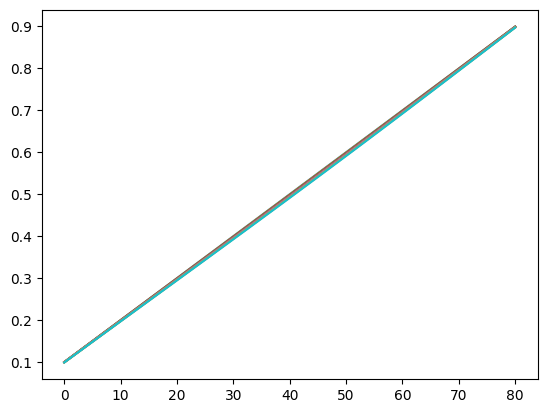

In [194]:
# sol - true trajectoires, how x changes based on integrating with alpha
solve_Beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

plt.plot(solve_Beta.y);

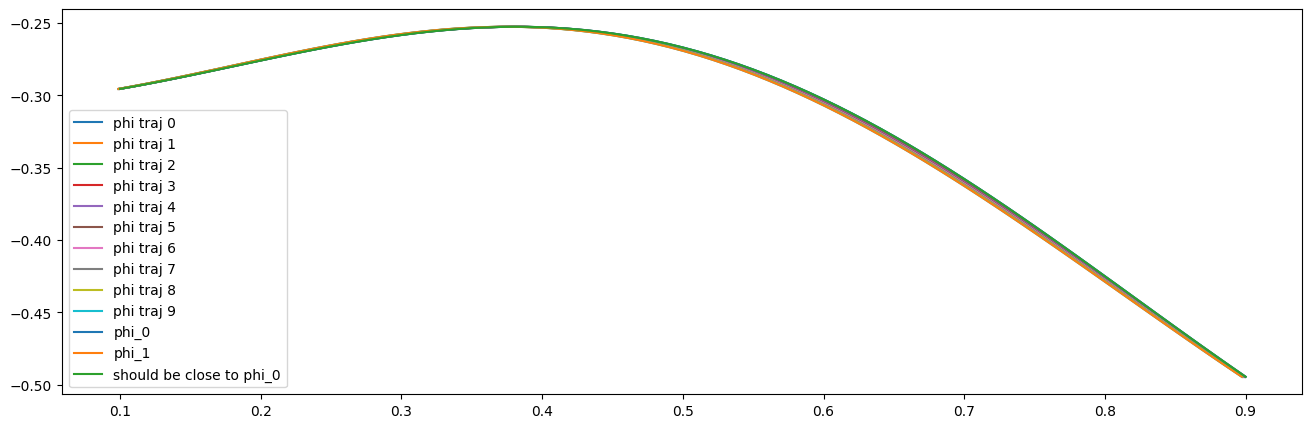

In [195]:
plt.figure(figsize=(16,5))
for i in range(len(solve_Beta.y[0])):
  plt.plot(solve_Beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (len(x_input),1))), label = 'should be close to phi_0')
plt.legend();


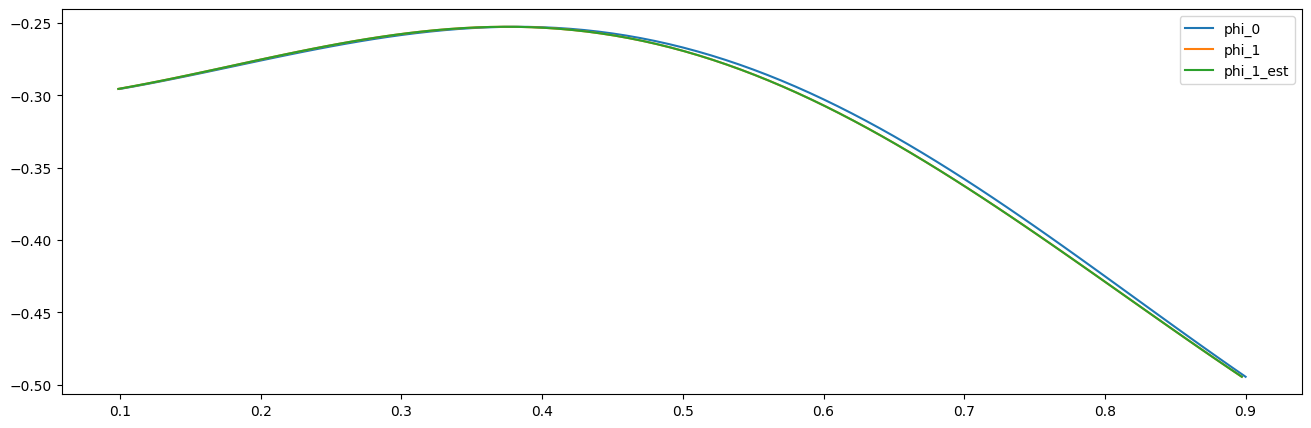

In [196]:

plt.figure(figsize = (16,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
#plt.plot(x_input, phi_1(np.reshape(solve_Beta.y[:,-1], (101,1))), label = 'should be close to phi_0');
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(np.reshape(solve_Beta.y[:,-1], (len(x_input),1)), np.transpose(phi_0(x_input)), label = 'phi_1_est')

plt.legend();

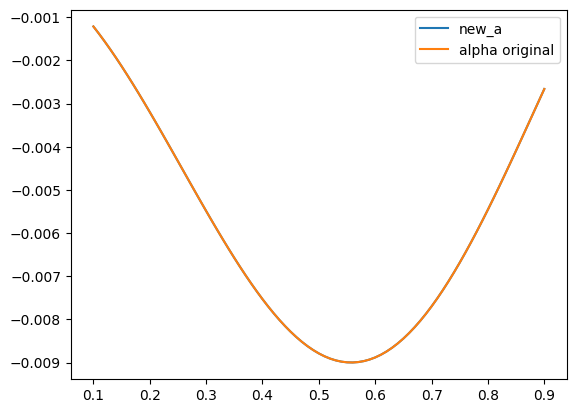

In [197]:
plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y,
                            num = num,
                            beta= Beta), label = 'new_a')
plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()

## Now try again.

### While loop testing ==> initialzed beta with beta_star_3 and instead of using a constant function for my initialized alpha, I choose another function h_func which was generated using the same method as alpha.

In [198]:
#sol2=solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list, vectorized = True)

1
obj_old with Beta: [[0.02084409]]
Here is the obj value for LSTAR: [[0.00251853]]
Is obj function for LSTAR NOT increasing?
The obj function is NOT increasing
(True, None)
The obj function is NOT increasing
2
obj_old with Beta: [[0.00251853]]
Here is the obj value for LSTAR: [[0.0016832]]
Is obj function for LSTAR NOT increasing?
The obj function is NOT increasing
(True, None)
The obj function is NOT increasing
3
obj_old with Beta: [[0.0016832]]
Here is the obj value for LSTAR: [[0.00082834]]
Is obj function for LSTAR NOT increasing?
The obj function is NOT increasing
(True, None)
The obj function is NOT increasing
4
obj_old with Beta: [[0.00082834]]
Here is the obj value for LSTAR: [[0.00016337]]
Is obj function for LSTAR NOT increasing?
The obj function is NOT increasing
(True, None)
The obj function is NOT increasing
5
obj_old with Beta: [[0.00016337]]
Here is the obj value for LSTAR: [[7.47809774e-06]]
Is obj function for LSTAR NOT increasing?
The obj function is NOT increasing
(

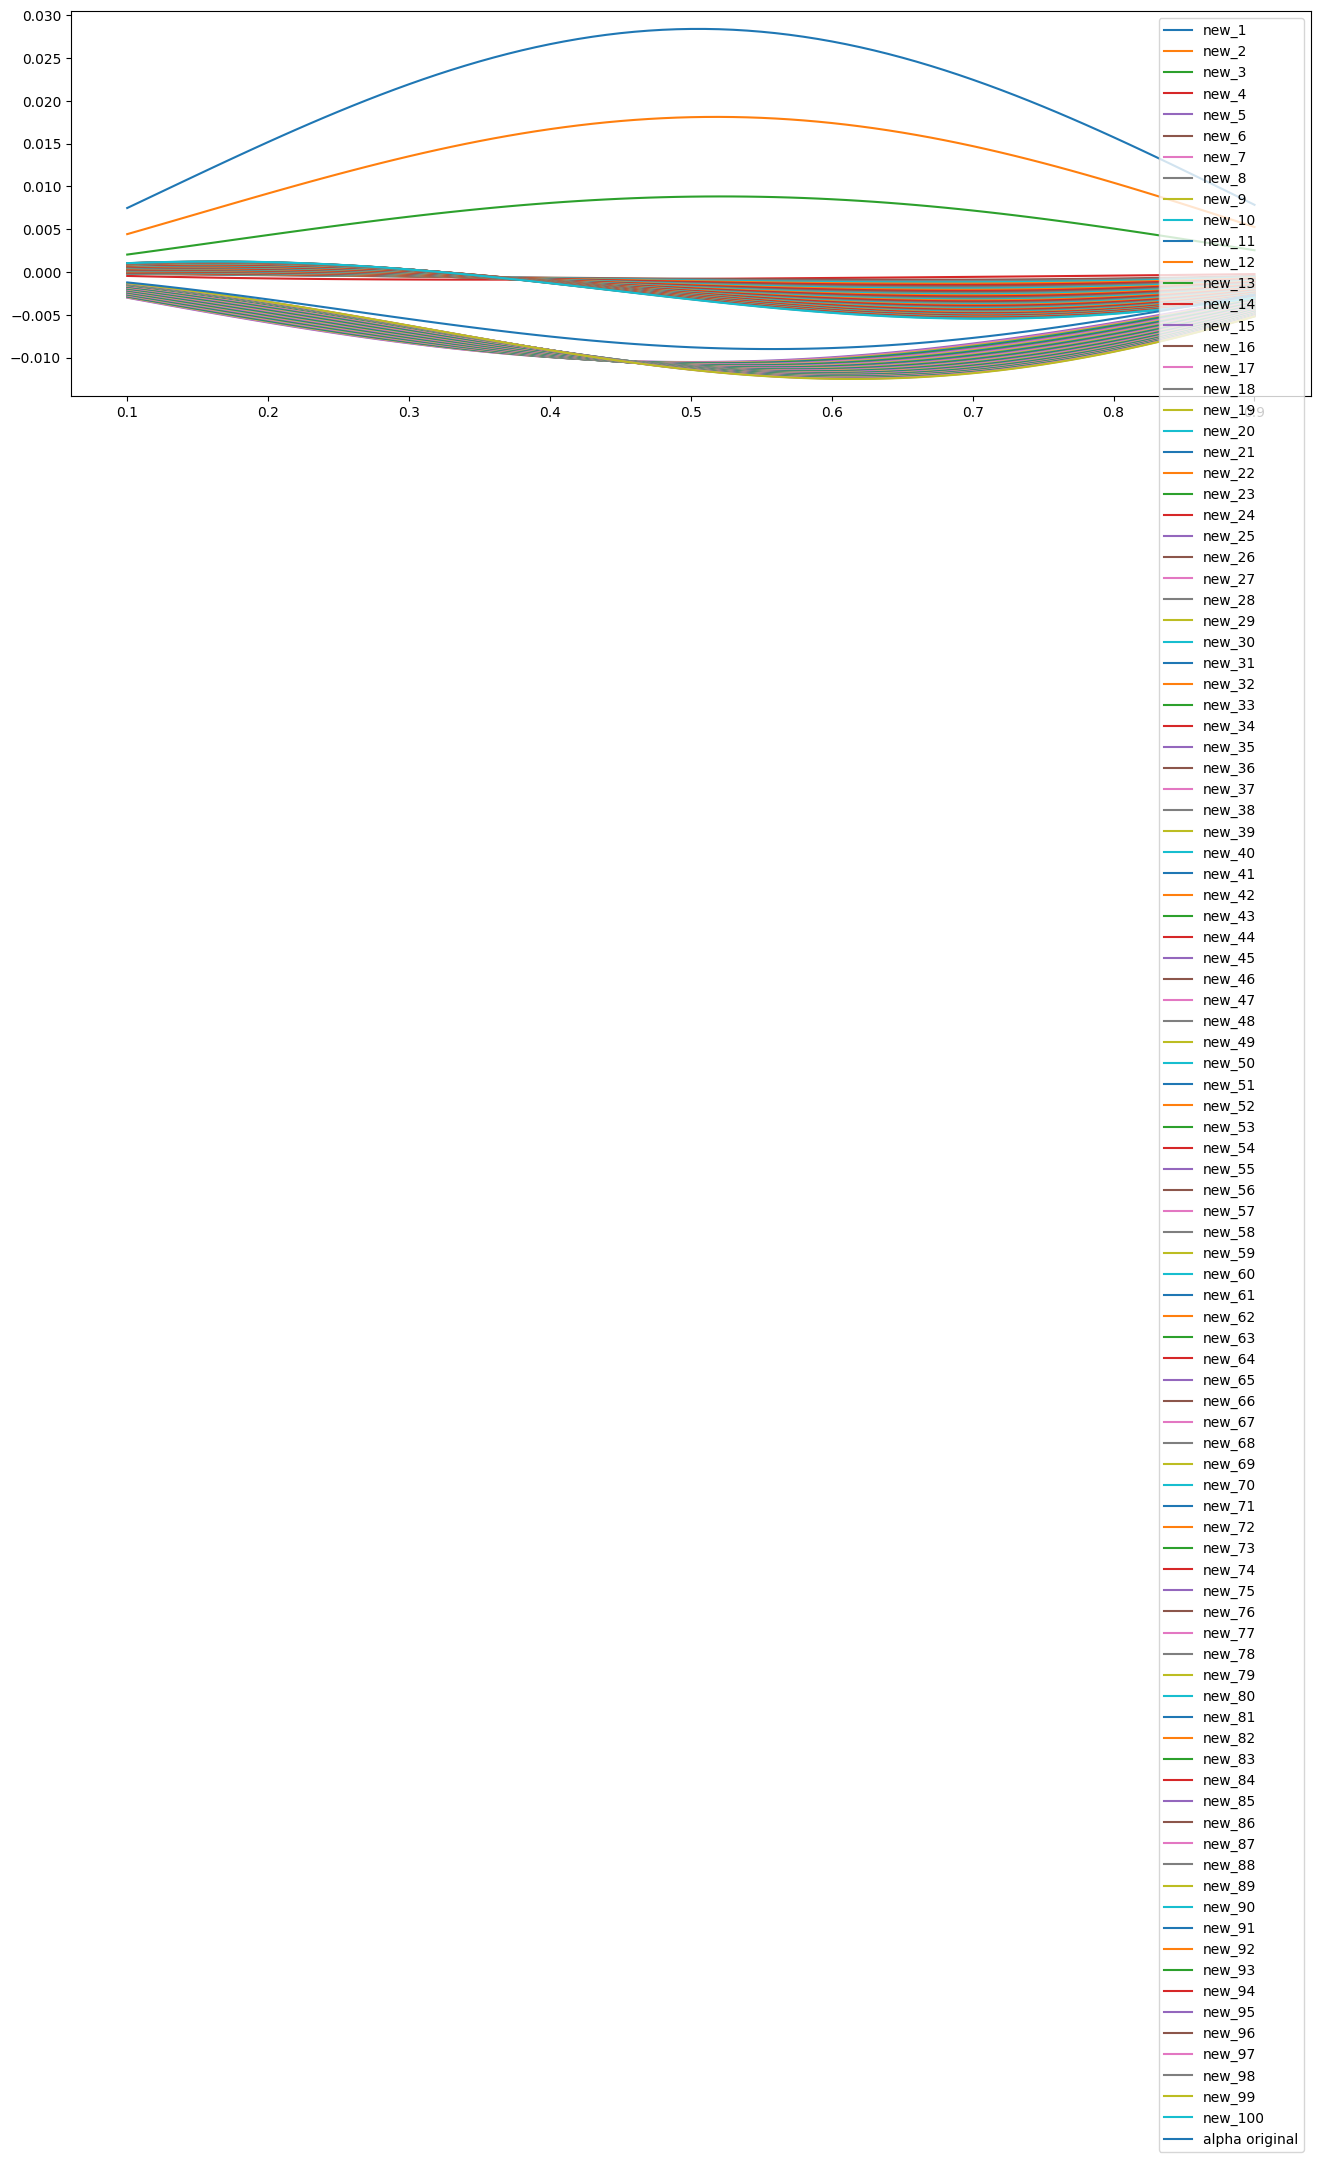

In [199]:
#TEST
#get start time
#eta = ((2**5)/(2**1)) * 1e-3 #(2**5) * 1e-3
#print(f"This is the first eta: {eta}")
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
var_2 = 0
LAM = (10**0) * 1e-6 #lambs[lambda_index] #1e-6
Beta = beta_scaled#beta_star_2 #Beta_ini #beta_star_2 #Beta_ini
#sol = sol_1.y
#LSTAR = Lsk_alpha #Lsk_alpha#  Lsk_alpha is with true trajectories, Lsk_0
OBJ = [] #put the results in this list to compare the elements for GD
OBJ_2 = [] #lstar obj restulst

#initialize the firts sol.y
# alpha_(not)
#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list, vectorized = True)
sol = solve_ivp(h_func,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list, vectorized = True)

##initial the first sol_alpha.y's with true trajecotires.
#sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

# initialize first LSTAR with sol.y from gamma function, alpha_(not)
LSTAR = con(1/(num-1), y = sol.y, num = num, kern = k9v)

# plot original alpha with Beta_ini
#plt.figure(figsize = (16,5))
#plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
#                            k8v,
#                            y = sol.y, #from constant function
#                            num = num,
#                            beta= Beta), label = 'initial alpha with Beta_ini'); #beta init
#plt.legend()
# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(16,5))

cond = True
cond_2 = True

while(cond):


    mm += 1
    print(mm)

    # Gradient Desecent
    for i in range(1):
    #while(cond_2):
      eta = 1 / (2**8)#2.5 * (1e-4)#3**1 * 1e-2 #.01

      Beta = tf.Variable(Beta)
      with tf.GradientTape() as tape:
          tape.watch(Beta)
          obj = objective(LSTAR, Beta, LAM)
          print(f"obj_old with Beta: {obj}")
          #print(f"This is gradient {i}th iteration obj_old: {obj}")


      beta_grad = tape.gradient(obj, Beta) # this is taking the gradient
      Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad)) # gradient desecent
      #Beta = Beta - eta * beta_grad

      #original obj function before descent:
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) #-1
      #make new obj with fixed LSTAR, and New Beta
      obj_new = objective(LSTAR, Beta, LAM)
      #print(f"obj_new with Beta after GD: {obj_new}")

      '''
      #kamel's test
      obj_1 = obj.numpy()  #make obj into a numpy
      obj_old = np.copy(obj_1) - 1
      #OBJ.append(float(obj_1)) #make numpy into a float
      '''
      '''
      #if decreasing(OBJ)[0] == False:
      while obj_new > obj_old: #obj_1 > obj_old:
        print("obj is increasing")
        #obj_old = np.copy(obj_1)

        print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
        #print(f"GD: print the var variable {var}")
        #cond = False #stop algorithm
        eta = eta / 2
        print(f"Eta changed: {eta}")
        Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
        #Beta = Beta - eta * beta_grad
        obj_new = objective(LSTAR, Beta, LAM)
        #obj_1 = obj.numpy() #make obj into a numpy
        #obj_old = np.copy(obj_1)
        # do GD
      '''
      # Storing the betas for calculating error later
      beta_vector[:,mm:mm+1] = Beta

      if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

        diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ L_star
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )

    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''

    #plot alpha_new with new Beta and previous sol.y's
    plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k8v,
                            y = sol.y,
                            num = num,
                            beta= Beta), label = f'new_{mm}')

    # create new sol's with NEW Beta from our new alpha function that
    # takes in sol.y values from before and Beta
    sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

    # calculate new LSTAR with new sol.y so we can use this
    # for objective function
    LSTAR = con(1/(num-1), sol.y, num, k8v)



    #if mm % 50 == 0:
    obj_2 = objective(LSTAR, Beta, LAM)
    obj_2 = obj_2.numpy() #make obj into a numpy
    OBJ_2.append(float(obj_2)) #make numpy into a float

    #var_2 += 1
    #if var_2 % 10 == 0:
    print(f"Here is the obj value for LSTAR: {obj_2}")
    print("Is obj function for LSTAR NOT increasing?")
    print(decreasing(OBJ_2))
    if decreasing(OBJ_2)[0] == False:
      print(f"LSTAR: This is the iteration where we stopped: {mm}")
      #cond = False

        #eta = eta / 2
        #print(f"objection funcion is increasing, change eta to: {eta}")

  #print(f"LSTAR change objective: {OBJ_2}")
  #print(f"LSTAR obj: {float(obj_2)}")
  # after gradient descent we should still decrease objective
  # compare to the last gradeint desecent objective print
  # compare the LSTAR
  # plot this
  #print(obj)

    if mm % 100 == 0:
      print(mm)
      print(f"Here is the objective function results at {mm} iterations: {objective(LSTAR, Beta, LAM)}")
      print(f"the value of eta: {eta}")
      cond = False # stop algorithm
      #if decreasing(OBJ)[0] and decreasing(OBJ_2)[0] == True:
      #  eta = eta / 2
#        print(f"this is the same eta: {eta}")
#      else:
#        eta = eta / 2
#        print(f"objection funcion is increasing, change eta to: {eta}")

plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#print("GD obj list: ")
#print(decreasing(OBJ))
#print("LSTAR obj list:")
#print(decreasing(OBJ_2))


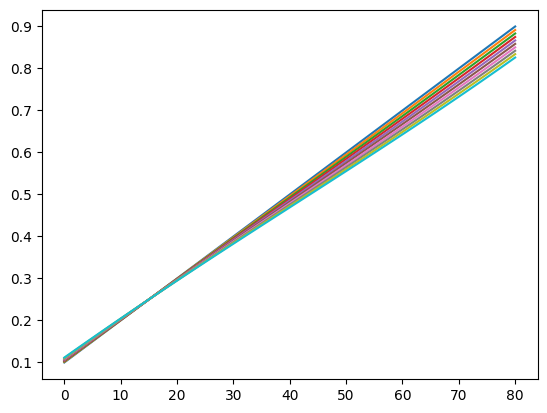

In [200]:
solve_beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol.y, num, Beta))

plt.plot(solve_beta.y);

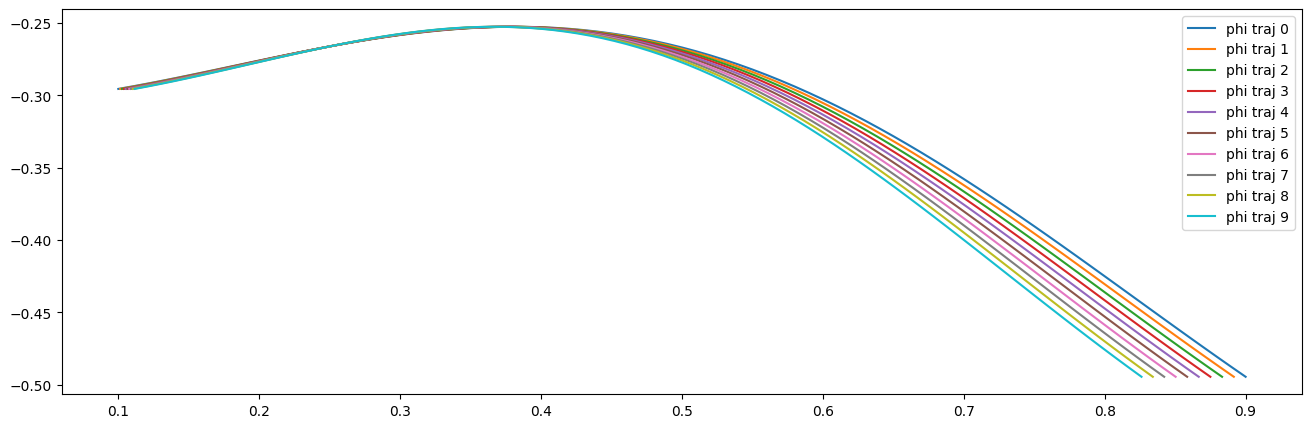

In [201]:
plt.figure(figsize=(16,5))
for i in range(len(solve_beta.y[0])):
  plt.plot(solve_beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')


plt.legend();

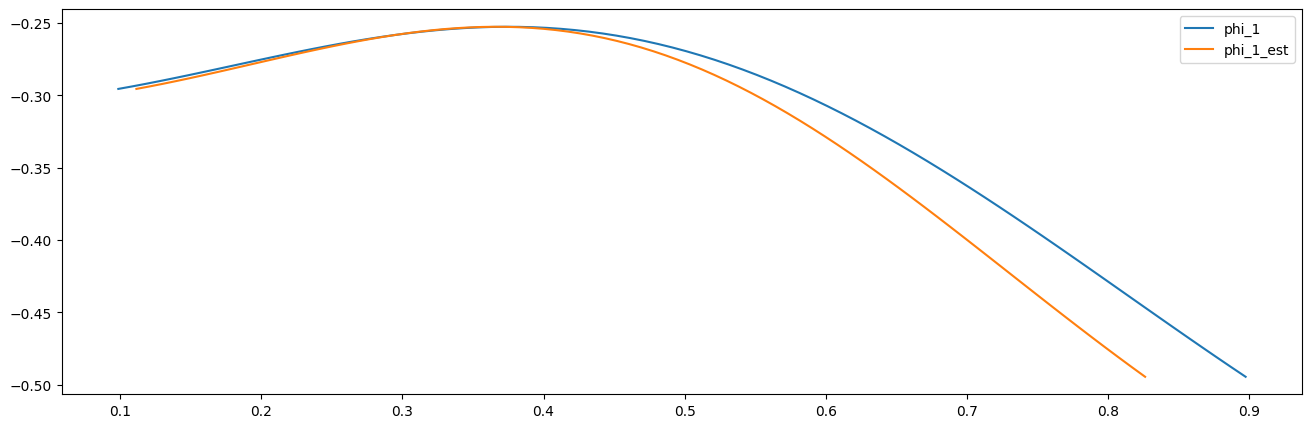

In [202]:
plt.figure(figsize=(16,5))
#plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1')
#plt.plot(x_input, phi_1(np.reshape(solve_beta.y[:,-1], (101,1))), label = 'should be close to phi_0')
plt.plot(solve_beta.y[:,-1],np.transpose(phi_0(x_input)), label = 'phi_1_est')
plt.legend();

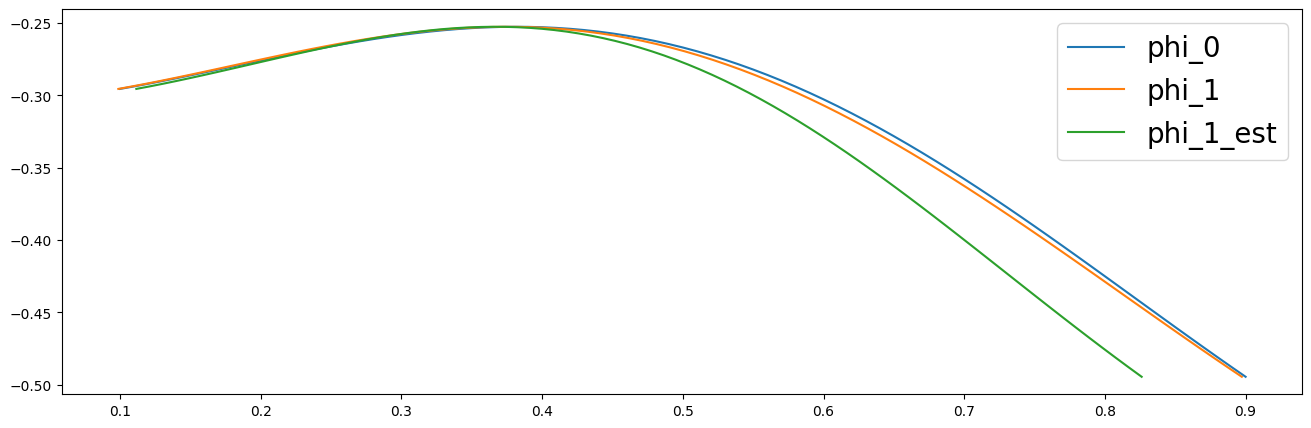

In [203]:

plt.figure(figsize=(16,5))
plt.plot(x_input, np.transpose(phi_0_fixed), label ='phi_0')
plt.plot(x_phi_1, np.transpose(phi_0_fixed), label = 'phi_1')

plt.plot((solve_beta.y[:,-1:] ), np.transpose(phi_0_fixed), label = "phi_1_est")

# now print the interpolated phi_1 wiht new x_phi_new and plot
# against x_input. This gives us what the values would be on x_input
# and compare to phi_1
#plt.plot(x_input, phi_1(x_phi_new[:,99:100]), label = "phi_1_est")
#plt.plot(x_input, phi_1(x_phi_new[:, 50:51]), label = "Phi_1_est midwaty")
#plt.plot(x_input, phi_1(x_phi_new[:, 0:1]), label = " phi_1_est first")


plt.legend(prop={'size':20});
plt.show()

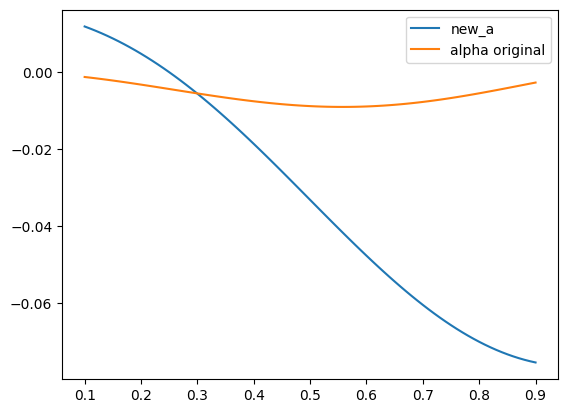

In [204]:

plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol.y,
                            num = num,
                            beta= Beta), label = 'new_a')
plt.plot(x_input, np.transpose(alph(1, x_input)), label = 'alpha original')
plt.legend()

## DTW

In [205]:
!pip install dtw-python

In [206]:
## Find the best match with the canonical recursion formula
from dtw import *


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



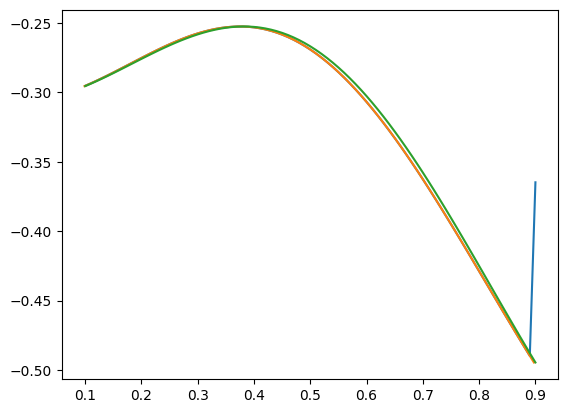

In [207]:
plt.plot(x_input, phi_1(x_input));
plt.plot(x_phi_1, np.transpose(phi_0(x_input)));
plt.plot(x_input, np.transpose(phi_0(x_input)));

<Axes: >

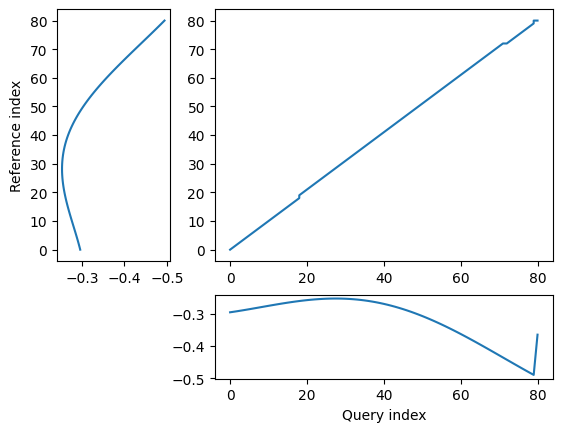

In [208]:
alignment = dtw(phi_1(x_input), np.transpose(phi_0(x_input)), keep_internals=True) #use phi_1 function to get phi_1

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

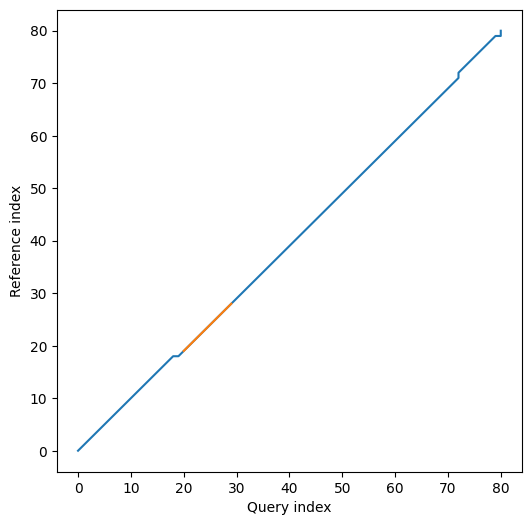

In [209]:
dtw(np.transpose(phi_0(x_input)),phi_1(x_input),  keep_internals=True,
    window_type="sakoechiba", window_args={'window_size': 10})\
    .plot()

plt.plot(alignment.index2[20:30],alignment.index1[20:30])

In [210]:
print(alignment.index1[20:30])
print(alignment.index2[20:30])
print(alignment.index2)
print(alpha_0)

[19 20 21 22 23 24 25 26 27 28]
[20 21 22 23 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 72 73 74 75 76 77 78 79 80 80]
[[-0.00121189 -0.00138182 -0.00155921 -0.00174365 -0.0019347  -0.00213193
  -0.00233486 -0.00254302 -0.00275592 -0.00297305 -0.0031939  -0.00341793
  -0.0036446  -0.00387337 -0.00410367 -0.00433495 -0.00456662 -0.00479812
  -0.00502887 -0.00525828 -0.00548577 -0.00571076 -0.00593267 -0.00615093
  -0.00636496 -0.00657419 -0.00677806 -0.00697604 -0.00716757 -0.00735214
  -0.00752922 -0.00769831 -0.00785894 -0.00801064 -0.00815295 -0.00828546
  -0.00840775 -0.00851944 -0.00862018 -0.00870961 -0.00878745 -0.0088534
  -0.00890721 -0.00894866 -0.00897754 -0.0089937  -0.00899701 -0.00898735
  -0.00896467 -0.00892893 -0.00888012 -0.00881827 -0.00874347 -0.00865579
  -0.00855538 -0.

In [211]:
## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
a = dtw(phi_1(x_input), np.transpose(phi_0(x_input)), distance_only=True)

In [212]:
a.distance

0.29047649149936156

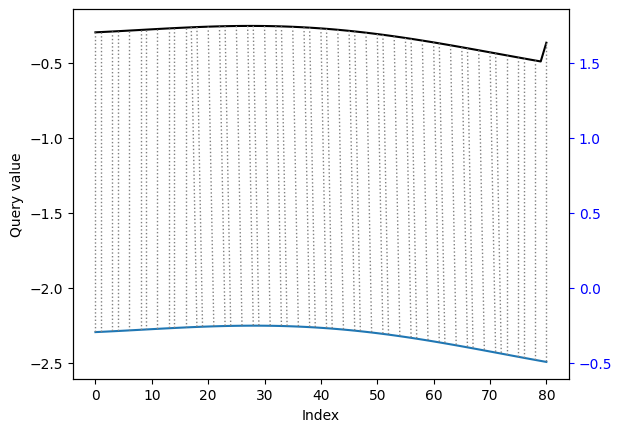

In [213]:
b = dtw(phi_1(x_input), np.transpose(phi_0(x_input)), keep_internals=True,
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2);

# Stop here

# Try and make another alpha using my function


Create $\alpha(x)$. Below is our quadrature for $\alpha$. Again $p$ is the number of intermediate trajectories we choose and $h = 1/p$.  Recall $\alpha(x) = \sum_{k=1}^n \beta_k L^*_{x_{k}}(x)$, where $L^*_{x_{k}}(x) = \int K(x_k(s),x)dt$.
\begin{align}
    &\int_0^1  K(x_k(s),x) ds \notag \\
    &\approx \frac{h}{2} K(x_k(s_0),x) + h  \sum_{i=1}^{p-1} K(x_k(s_i),x) + \frac{h}{2}  K(x_k(s_p),x)
\end{align}
We use the trapezoid composite rule where $k \in \lbrace 1, \dots, n\rbrace$ and $i \in \lbrace 0,\dots, p-1 \rbrace$ for our function $\alpha$.

In [214]:
# creating theta3 for alpha,
np.random.seed(1)
theta3 = np.random.normal(scale = 10 / np.sqrt(num_features_alpha), size = ((101, 1))) /20
theta3 = tf.constant(theta3)

In [215]:
theta3.shape

TensorShape([101, 1])

In [216]:
#'''
# This is 'new' original alpha
# sol_1 comes from the integration of a constant function
# new_alpha function comes from description above
plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol_1.y,
                            num = num,
                            beta= theta3))
print(new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol_1.y,
                            num = num,
                            beta= theta3).shape)
#'''

ValueError: ignored

In [ ]:
# sol_1 comes from the integration of our gamma constant function
# true trajectoires, how x changes based on integrating with alpha
solve = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol_1.y, num, theta3))

plt.plot(solve.y);

In [ ]:
'''
#forward euler, used above runga kutta
#x_input = tf.reshape(x_input, (tf.size(x_input),1))
x_phi_1_test = tf.zeros((tf.size(x_input),1))
v = x_input
#v = v.numpy()
plt.figure() # this places a figure in begining
             # then i can plot the figures of the loops in this
for i in range(k_x+1):
    plt.plot(v)
    v = v + h_x * new_alpha(1, np.reshape(v,(len(v))), k8v, sol_1.y, num, theta3, h = (1/(num-1)))
x_phi_1_test = v
#'''

In [ ]:
# True phi trajectries. Phi_0 to phi_1
plt.figure(figsize = (16,5));
for i in range(len(solve.y[0])):
  plt.plot(solve.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')
  plt.legend();

In [ ]:
#'''
# this is important. phi_0 is agains x(0), phi_1 is phi_0 is agains x(1)
plt.figure(figsize=(10,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
#same plot here, test
#plt.plot(solve.y[:,0], np.transpose(phi_0(x_input)), label = 'phi_1_test') # this is phi_1. its the new x_input after
                                                                  # forward euler, then plot this agains

plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1') ##

#plt.plot(x_phi_1, np.transpose(phi_0(x_input)), label = 'phi_1_original')                                                                   # phi_0 true values
plt.legend(prop={'size':20});
plt.show()
#'''

Here I am using true trajectories to input into our L* equation. Then use our true alpha function.

\begin{align}
   L^* =  &\int_0^1 \int_0^1  K(x_k(s),x_l(t) dsdt \notag\\
    &\approx \frac{h^2}{4} \left[ K(x_k(s_0),x_l(t_0) +K(x_k(s_0),x_l(t_{p}) \right.\notag \\
    & \left. + K(x_k(s_{p}),x_l(t_0)  +K(x_k(s_{p}),x_l(t_{p}) \right] \notag\\
    & +\frac{h^2}{2} \left[ \sum_{j=1}^{p-1} K(x_k(s_0),x_l(t_j) +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_{p})+\sum_{j=1}^{p-1}K(x_k(s_{p}),x_l(t_j) \right. \notag \\
    &\left. +\sum_{i=1}^{p-1}K(x_k(s_i),x_l(t_0) \right]  +  h^2 \left[ \sum_{j=1}^{p-1} \sum_{i=1}^{p-1} K(x_k(s_i),x_l(t_j)\right]
\end{align}
where $k,l \in \lbrace 0, \dots, n\rbrace$, $i,j \in \lbrace 1,\dots p-1 \rbrace$ ($p$ is the number of intermediate trajectories ($x_i)$ we choose), and for our given bounded $[0,1]$ interval, $h = (1-0)/p$.  Use the convolve function to find this value.


$$ J(\beta, \lambda)  = \frac{1}{n} \sum_{i=1}^n [\phi_1 \bigg( x_i(0) + [L^*\beta]_i \bigg) - \phi_0(x_i(0))]^2 + \lambda \beta^T L^* \beta$$

In [ ]:
# test to make sure double integral is working
L_star = np.zeros((101,101))
print(solve.y.shape)
#result_1 = K_Lstar(solve.y, solve.y, h = h_x, kern = k8v)
#result_1 = tf.convert_to_tensor(result_1)
#print(result_1.shape)
for i in range(101):
    for j in range(101):
        L_star[i,j] = K_Lstar(solve.y[i:i+1,:].T, solve.y[j:j+1,:].T, (1/(num-1)), k9v).sum()


result_2 = con(1/(num-1), y = solve.y, num = num, kern = k9v)
print(result_2.shape)




print(objective(result_2, theta3, LAM))


In [ ]:
print(objective(L_star, theta3, LAM))

In [ ]:
# let's look at objective function with TRUE trajectories:
# Our goal is to show that phi_1(x(1)) ~ phi_0(X(0)), i.e. our outputs should
# equal for phi_1 and phi_0. Using our objection function, I calculted phi_1(x(0) + LB). This
# should be very close to phi_0(X(0)).


LAM = 10**2 * 1e-6

# theta3 is used for alpha.
# solve.y uses our true x trajectoires
# this LSTAR uses true x trajectories to solve for obj function
LSTAR = con(1/(num-1), y = solve.y, num = num, kern = k9v)

print(f"this is from the objective function with theta3: {objective(LSTAR, theta3, LAM)}")

########
#Test out objective function
########
LB = tf.matmul(LSTAR, theta3) #Beta_ini)
#print(LB)
print(LB.shape)
BTLB = tf.matmul(tf.transpose(theta3), LB) #tf.matmul(tf.transpose(Beta_ini), LB)
print(LAM * BTLB)

############
input = x_input + LB
print(input.shape)
phi_1_est = phi_1(input)
error = (phi_1_est - tf.transpose(phi_0_fixed))**2
print(f'error norm: {np.linalg.norm(phi_1_est - tf.transpose(phi_0_fixed))/101}')
summ_1 = tf.reduce_sum(error, axis = 0)
loss_test = ((1 / (len(x_input)) ) * summ_1) + LAM * BTLB
print(f'loss function test: {loss_test}')
print(f'loss function with Beta_ini: f{objective(LSTAR, Beta_ini, LAM)}')

plt.figure(figsize=(10,5))
#plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1_original')

# these values should be close, regardless of what they are being plotted against.
plt.plot(x_input, phi_1_est, label = 'should be close phi_0');
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0_original')


plt.legend();

In [ ]:
plt.plot(input)
plt.plot(solve.y[:,-1])

In [ ]:
#print(input)
#print(x_input[:10])
#print(solve.y[:,-1])
print(np.linalg.norm(phi_1_est - np.transpose(phi_0(x_input))))

## $\alpha$ function update while loop

In [ ]:

#get start time
#eta = (2**5) * 1e-3 #(2**5) * 1e-3
st = time.time()
mm = 0 # not zero since beta_ini is zero vector at virst
        # we can't divide by zero
var = 0
LAM = 1 * 1e-6 #lambs[lambda_index] #1e-6
Beta = Beta_ini
#Sol.y = sol.y
#LSTAR = Lsk_0

#sol = solve_ivp(f,[0,1],np.reshape(x_input,len(x_input)),t_eval=t_list)

# sol_1.y is just my fixed one.  Don't change this for test
# this is my true trajecotries using the alpha fixing sol_1.y
# then put this into LSTAR for objective function
# this is my true alpha being solved to x_phi_1 with 10 trajcetories
solve = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol_1.y, num, theta3))
# this LSTAR usis solve.y to solve for obj function
LSTAR = con(1/(num-1), y = solve.y, num = num, kern = k9v)


# measuring error
beta_vector = np.zeros((len(x_input),600))
beta_vector[:,0:1] = Beta  #put beta in first column
diff_beta = np.zeros(100)
diff = np.zeros(600)
plt.figure(figsize=(10,5))

cond = True


while(cond):

  mm += 1
  #print(mm)

  # Gradient Desecent
  for i in range(1):
    eta = 1 / (2**4)
    print(eta)


    Beta = tf.Variable(Beta)
    with tf.GradientTape() as tape:
        tape.watch(Beta)
        obj = objective(LSTAR, Beta, LAM)
        print(f"obj_old with Beta: {obj}")


    beta_grad = tape.gradient(obj, Beta) # this is taking the gradient

    Beta = Beta - eta * (beta_grad / np.linalg.norm(beta_grad))

    #Beta = Beta - eta * beta_grad   # gradient desecn

    obj_1 = obj.numpy()  #make obj into a numpy
    obj_old = np.copy(obj_1) #-1
    #make new obj
    obj_new = objective(Lsk_alpha, Beta, LAM)
    print(f"obj_new with Beta after GD: {obj_new}")

    '''
    #kamel's test
    obj_1 = obj.numpy()  #make obj into a numpy
    obj_old = np.copy(obj_1) - 1
    #OBJ.append(float(obj_1)) #make numpy into a float
    '''

    #if decreasing(OBJ)[0] == False:
    while obj_new > obj_old: #obj_1 > obj_old:
      print("obj is increasing")
      #obj_old = np.copy(obj_1)

      print(f"GD: This is the iteration where it increased: {mm}, {obj_new} > {obj_old}")
      #print(f"GD: print the var variable {var}")
      #cond = False #stop algorithm
      eta = eta / 2
      print(f"Eta changed: {eta}")
      Beta = Beta - eta *  (beta_grad / np.linalg.norm(beta_grad))
      #Beta = Beta - eta * beta_grad
      obj_new = objective(Lsk_alpha, Beta, LAM)





    # error
    beta_vector[:,mm:mm+1] = Beta

    if mm >= 2: # after 2 since beta = 0 at the first iteration, we need the second and third composnents.
      # check for convergence, using relative error
      #diff_beta[mm] = np.linalg.norm(beta_vector[:,mm-1:mm] - beta_vector[:,mm:mm+1]) / np.linalg.norm(beta_vector[:,mm-1:mm])
      #print(diff_beta[mm])
      #if diff_beta[mm] < 1e-2:
      #  print(diff_beta[mm])
      #  cond_2 = False
      #  break

      diff[mm] = np.sqrt( ((beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm]).T @ LSTAR @
                                                    (beta_vector[:,mm:mm+1] - beta_vector[:,mm-1:mm])
                                                    ) / (beta_vector[:,mm-1:mm].T @ L_star
                                                         @ beta_vector[:,mm-1:mm] )
                                                      )
      #print("This should be the same: ", {diff[mm]})


    #if mm % 4 == 0:  #if m modulo constant occurs, print m
    #    rem = mm
    #    print('Iteration count: ' +str(rem))
    #    print('Convergence using norm of RKHS at '+str(rem) +'iterations: ' +str(diff[mm]))
    #    print('Beta norm error: '+str(diff[mm]))
    #'''
    '''  if diff[mm] < 0.01:
        print('This is the norm difference of the RKHS norm: ', {diff[mm]})
          #print('Iteration count: ' +str(mm))
          #print('Convergence using norm of RKHS at '+str(mm) +'iterations: ' +str(diff[mm]))
          #print('Beta norm error: '+str(diff[mm]))
        cond_2 = False
    '''
    #'''
  # ODEvsolver. Put arguments for sol.y and num in here
  #'''
  #'''
  #sol = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
  #                t_eval=t_list,
  #                vectorized = True,
  #                args=(k8v, sol.y, num, Beta))

  #this is my true alpha function with sol_1.y but now with Beta
  plt.plot(x_input, new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k9v,
                            y = sol_1.y,
                            num = num,
                            beta= Beta), label = f'new_{mm}')
  #'''
  #'''

  # test out original alpha
  #sol = solve_ivp(alpha,[0,1], np.reshape(x_input, len(x_input)), t_eval = t_list, vectorized = True)

  #Make new L_star with ODE solver data
  #LSTAR = con(h_x, sol.y, num, k8v)

  if mm == 15:
    print(mm)
    print(f"Here is the objective function results at the end {objective(LSTAR, Beta, LAM)}")
    cond = False

plt.plot(x_input, (new_alpha(1, np.reshape(x_input,(len(x_input))),
                            k8v,
                            y = sol_1.y,
                            num = num,
                            beta= theta3)), label = 'alpha_original')
plt.legend()
print(obj)
et = time.time()
total_time = et - st
print(total_time)
#'''

In [ ]:
'''
x_phi_new_test = np.zeros((tf.size(x_input), k_x+1))
print(x_phi_new_test.shape)
v = x_input
v = v.numpy()
x_phi_new_test[:,0:1] = v
print(v.shape)
plt.figure(figsize=(16,5)) # this places a figure in begining
             # then i can plot the figures of the loops in this
for i in range(k_x+1):
  #print(i)
  plt.plot(x_phi_new_test[:,i:i+1], np.transpose(phi_0_fixed))
  #for new_alpha:
  v = v + h_x * new_alpha(1, np.reshape(v,(len(v))), k8v, solve.y, num, Beta, h = (1/(num-1)))

  # original alpha
  #v = v + h_x *  tf.transpose(alpha(1, v))

  x_phi_new_test[:,i+1:i+2] = v

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(x_phi_new_test[:,-1], (101,1))), label = 'should be close to phi_0')
plt.legend(prop={'size':20});
plt.show()
'''

In [ ]:
solve_beta = solve_ivp(new_alpha,[0,1],np.reshape(x_input,len(x_input)),
                  t_eval=t_list,
                  vectorized = True,
                  args=(k9v, sol_1.y, num, Beta))

plt.plot(solve_beta.y);

In [ ]:
plt.figure(figsize=(16,5))
for i in range(len(solve_beta.y[0])):
  plt.plot(solve_beta.y[:,i], np.transpose(phi_0(x_input)), label = f'phi traj {i}')

plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1')
plt.plot(x_input, phi_1(np.reshape(solve.y[:,-1], (101,1))), label = 'should be close to phi_0')
plt.legend();

In [ ]:
#'''
plt.figure(figsize=(16,5))
plt.plot(x_input, np.transpose(phi_0(x_input)), label ='phi_0')
plt.plot(solve.y[:,-1], np.transpose(phi_0(x_input)), label = 'phi_1')

#plt.plot((x_phi_new_test[:,-1:] ), np.transpose(phi_0_fixed), label = "phi_1_est")
plt.plot(x_input, phi_1(np.reshape(solve_beta.y[:,-1], (101,1))), label = 'should be close to phi_0')

# now print the interpolated phi_1 wiht new x_phi_new and plot
# against x_input. This gives us what the values would be on x_input
# and compare to phi_1
#plt.plot(x_input, phi_1(x_phi_new[:,99:100]), label = "phi_1_est")
#plt.plot(x_input, phi_1(x_phi_new[:, 50:51]), label = "Phi_1_est midwaty")
#plt.plot(x_input, phi_1(x_phi_new[:, 0:1]), label = " phi_1_est first")


plt.legend(prop={'size':20});
plt.show()
#'''

In [ ]:
import numpy as np

In [ ]:
x_1 = np.array([[0],[1]])

In [ ]:
x_1.shape